In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingclfressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
levels_up = 3
HDAC1= HERE.parents[levels_up-1]/'input'

In [3]:
df = pd.read_pickle(HDAC1/"HDAC1_4492compounds_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl
0,CHEMBL4516302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9413970, 1506859, 7998790, 22094156, 553789, ...",342.157957,8.0,25.0,5.0,3.0,2.5122,2.0,0.0,0.0,6.22
1,CHEMBL4067265,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[926304, 2662097, 582748, 1458307, 1038221, 43...",666.410483,16.0,48.0,6.0,6.0,3.3354,2.0,1.0,1.0,7.38
2,CHEMBL481211,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[3192076, 3346815, 1578989, 11956864, 15143291...",396.169859,6.0,30.0,6.0,3.0,3.9852,4.0,0.0,0.0,6.96
3,CHEMBL4648704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2322832, 4026098, 991465, 1396494, 3858537, 9...",546.320606,13.0,40.0,7.0,1.0,6.1073,3.0,2.0,2.0,9.05
4,CHEMBL3758354,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[7275495, 10511, 8033062, 5854825, 11301804, 1...",407.167891,12.0,28.0,5.0,3.0,3.7740,2.0,0.0,0.0,6.89


In [4]:
df_labeled = pd.read_csv(HDAC1/"HDAC1_4492compounds_withTypes-Ki_newThreshold.csv", index_col=0)
df_labeled.head(4)

,molecule_chembl_id,smiles,pActivity,label
0,CHEMBL327146,O=C(CCCCCC(C(=O)Nc1ccc2ncccc2c1)C(=O)Nc1ccc2nc...,9.00,Single points
1,CHEMBL116620,O=C(/C=C/c1cccc(C(C(=O)Nc2ccccc2)C(=O)Nc2ccccc...,9.00,Single points
2,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,5.20,Single points
3,CHEMBL316457,CC(C)c1cc(C(C)C)c(S(=O)(=O)Nc2ccc(/C=C/C(=O)NO...,6.22,Single points


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')

In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl,label,Class
0,CHEMBL4516302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9413970, 1506859, 7998790, 22094156, 553789, ...",342.157957,8.0,25.0,5.0,3.0,2.5122,2.0,0.0,0.0,6.22,Single points,0.0
1,CHEMBL4067265,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[926304, 2662097, 582748, 1458307, 1038221, 43...",666.410483,16.0,48.0,6.0,6.0,3.3354,2.0,1.0,1.0,7.38,Single points,0.0
2,CHEMBL481211,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[3192076, 3346815, 1578989, 11956864, 15143291...",396.169859,6.0,30.0,6.0,3.0,3.9852,4.0,0.0,0.0,6.96,Single points,0.0
3,CHEMBL4648704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2322832, 4026098, 991465, 1396494, 3858537, 9...",546.320606,13.0,40.0,7.0,1.0,6.1073,3.0,2.0,2.0,9.05,Single points,0.0


In [7]:
# Add column for selectivity
df["activity"] = np.zeros(len(df))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
df.loc[df[df.pchembl >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
indices =  np.array(df.index)
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y =  df["activity"].values
Y_class = df['Class'].values

In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_clf =  RandomForestClassifier(random_state=1121218, max_features = None, n_jobs=8,oob_score=True,
                                           max_samples=0.8, )
        rf_clf.fit(x_train, y_train)
        y_pred = rf_clf.predict(x_test)  
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)



mat_met_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    TP       203.500000     8.996913
1                    TN       169.100000     7.908505
2                    FP        43.900000     7.880355
3                    FN        32.700000     5.888784
4              Accuracy         0.829465     0.021203
5             Precision         0.822792     0.029642
6           Sensitivity         0.861604     0.023819
7           Specificity         0.794280     0.033061
8              F1 score         0.841413     0.020672
9   F1 score (weighted)         0.829129     0.021288
10     F1 score (macro)         0.828320     0.021256
11    Balanced Accuracy         0.827945     0.020965
12                  MCC         0.658442     0.041817
13                  NPV         0.838230     0.026797
14              ROC_AUC         0.827945     0.020965
CPU times: user 4min 10s, sys: 105 ms, total: 4min 10s
Wall time: 33.6 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestClassifier(**param_grid, n_jobs=8, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = f1_score(y_test, y_pred,  average="macro")
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestClassifier(**param_grid, n_jobs=8, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFclassifier")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 15:39:41,859] A new study created in memory with name: RFclassifier
[I 2023-02-16 15:42:45,153] Trial 0 finished with value: 0.82400262448396 and parameters: {'n_estimators': 705}. Best is trial 0 with value: 0.82400262448396.
[I 2023-02-16 15:46:47,257] Trial 1 finished with value: 0.8236614019505788 and parameters: {'n_estimators': 950}. Best is trial 0 with value: 0.82400262448396.
[I 2023-02-16 15:50:38,252] Trial 2 finished with value: 0.8231117785792496 and parameters: {'n_estimators': 844}. Best is trial 0 with value: 0.82400262448396.
[I 2023-02-16 15:53:03,158] Trial 3 finished with value: 0.8200781856127908 and parameters: {'n_estimators': 418}. Best is trial 0 with value: 0.82400262448396.
[I 2023-02-16 15:55:31,651] Trial 4 finished with value: 0.8219785398759332 and parameters: {'n_estimators': 489}. Best is trial 0 with value: 0.82400262448396.
[I 2023-02-16 15:57:32,629] Trial 5 finished with value: 0.8217699811110941 and parameters: {'n_estimators': 472}. 

[I 2023-02-16 17:57:13,977] Trial 46 finished with value: 0.8238933724530296 and parameters: {'n_estimators': 867}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:00:39,276] Trial 47 finished with value: 0.8236715695564649 and parameters: {'n_estimators': 747}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:01:46,947] Trial 48 finished with value: 0.8232171559085131 and parameters: {'n_estimators': 190}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:06:41,780] Trial 49 finished with value: 0.8233585988413973 and parameters: {'n_estimators': 963}. Best is trial 35 with value: 0.8250674264961845.


	Number of trials: 50.0
	Best value (f1_score): 0.8251
	Best params:
		n_estimators: 777


In [14]:
optimized_rf_0 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_rf_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_rf_0)
Precision = precision_score(Y_testSet0, y_pred_rf_0)
Sensitivity = recall_score(Y_testSet0, y_pred_rf_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_rf_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_rf_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_rf_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_rf_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_rf_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_rf_0)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP), np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    TP  396.000000
1                    TN  343.000000
2                    FP   91.000000
3                    FN   69.000000
4              Accuracy    0.822024
5             Precision    0.813142
6           Sensitivity    0.851613
7           Specificity    0.790300
8              F1 score    0.831933
9   F1 score (weighted)    0.821767
10     F1 score (macro)    0.821404
11    Balanced Accuracy    0.820968
12                  MCC    0.643798
13                  NPV    0.832500
14              ROC_AUC    0.820968


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 18:08:42,886] Trial 50 finished with value: 0.8161567351633501 and parameters: {'n_estimators': 382}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:11:48,889] Trial 51 finished with value: 0.8173362597959943 and parameters: {'n_estimators': 714}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:14:14,569] Trial 52 finished with value: 0.81650717118186 and parameters: {'n_estimators': 567}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:17:01,700] Trial 53 finished with value: 0.8178819987734098 and parameters: {'n_estimators': 645}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:20:26,747] Trial 54 finished with value: 0.8167787958047745 and parameters: {'n_estimators': 791}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 18:24:01,046] Trial 55 finished with value: 0.8170321224559745 and parameters: {'n_estimators': 685}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-1

[I 2023-02-16 20:36:08,474] Trial 97 finished with value: 0.8170499131947848 and parameters: {'n_estimators': 684}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 20:39:35,166] Trial 98 finished with value: 0.8170695116456048 and parameters: {'n_estimators': 762}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 20:43:15,276] Trial 99 finished with value: 0.8165064766249859 and parameters: {'n_estimators': 809}. Best is trial 35 with value: 0.8250674264961845.


	Number of trials: 100.0
	Best value (f1_score): 0.8251
	Best params:
		n_estimators: 777


In [16]:
optimized_rf_1 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_rf_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_rf_1)
Precision = precision_score(Y_testSet1, y_pred_rf_1)
Sensitivity = recall_score(Y_testSet1, y_pred_rf_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_rf_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_rf_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_rf_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_rf_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_rf_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_rf_1)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    TP  396.000000  403.000000
1                    TN  343.000000  352.000000
2                    FP   91.000000   91.000000
3                    FN   69.000000   53.000000
4              Accuracy    0.822024    0.839822
5             Precision    0.813142    0.815789
6           Sensitivity    0.851613    0.883772
7           Specificity    0.790300    0.794600
8              F1 score    0.831933    0.848421
9   F1 score (weighted)    0.821767    0.839437
10     F1 score (macro)    0.821404    0.839305
11    Balanced Accuracy    0.820968    0.839177
12                  MCC    0.643798    0.681632
13                  NPV    0.832500    0.869100
14              ROC_AUC    0.820968    0.839177


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 20:46:16,229] Trial 100 finished with value: 0.8147372518716034 and parameters: {'n_estimators': 569}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 20:49:30,086] Trial 101 finished with value: 0.8142267070593745 and parameters: {'n_estimators': 708}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 20:52:50,892] Trial 102 finished with value: 0.8147927612508876 and parameters: {'n_estimators': 725}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 20:55:46,124] Trial 103 finished with value: 0.8141989921068783 and parameters: {'n_estimators': 636}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 20:59:42,633] Trial 104 finished with value: 0.8158764605241853 and parameters: {'n_estimators': 850}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 21:02:32,029] Trial 105 finished with value: 0.8139272115703149 and parameters: {'n_estimators': 616}. Best is trial 35 with value: 0.8250674264961845.
[I 2

[I 2023-02-16 23:20:38,964] Trial 146 finished with value: 0.8147718831609103 and parameters: {'n_estimators': 749}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:24:23,147] Trial 147 finished with value: 0.8161447100025043 and parameters: {'n_estimators': 814}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:27:25,249] Trial 148 finished with value: 0.8139313901301491 and parameters: {'n_estimators': 663}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:30:42,975] Trial 149 finished with value: 0.815348678046338 and parameters: {'n_estimators': 716}. Best is trial 35 with value: 0.8250674264961845.


	Number of trials: 150.0
	Best value (f1_score): 0.8251
	Best params:
		n_estimators: 777


In [18]:

optimized_rf_2 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_rf_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_rf_2)
Precision = precision_score(Y_testSet2, y_pred_rf_2)
Sensitivity = recall_score(Y_testSet2, y_pred_rf_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_rf_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_rf_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_rf_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_rf_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_rf_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_rf_2)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    TP  396.000000  403.000000  405.000000
1                    TN  343.000000  352.000000  344.000000
2                    FP   91.000000   91.000000   80.000000
3                    FN   69.000000   53.000000   70.000000
4              Accuracy    0.822024    0.839822    0.833148
5             Precision    0.813142    0.815789    0.835052
6           Sensitivity    0.851613    0.883772    0.852632
7           Specificity    0.790300    0.794600    0.811300
8              F1 score    0.831933    0.848421    0.843750
9   F1 score (weighted)    0.821767    0.839437    0.833021
10     F1 score (macro)    0.821404    0.839305    0.832376
11    Balanced Accuracy    0.820968    0.839177    0.831976
12                  MCC    0.643798    0.681632    0.664960
13                  NPV    0.832500    0.869100    0.830900
14              ROC_AUC    0.820968    0.839177    0.831976


In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 23:35:11,827] Trial 150 finished with value: 0.8116479420913203 and parameters: {'n_estimators': 903}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:38:33,661] Trial 151 finished with value: 0.813519797505105 and parameters: {'n_estimators': 766}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:41:48,659] Trial 152 finished with value: 0.8140745314901178 and parameters: {'n_estimators': 737}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:45:20,896] Trial 153 finished with value: 0.813248988297544 and parameters: {'n_estimators': 799}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:48:27,525] Trial 154 finished with value: 0.8129677335487792 and parameters: {'n_estimators': 694}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-16 23:51:40,381] Trial 155 finished with value: 0.8123877305976995 and parameters: {'n_estimators': 712}. Best is trial 35 with value: 0.8250674264961845.
[I 202

[I 2023-02-17 02:21:40,067] Trial 196 finished with value: 0.8140842163553188 and parameters: {'n_estimators': 750}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-17 02:25:50,163] Trial 197 finished with value: 0.8124681209129271 and parameters: {'n_estimators': 922}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-17 02:28:55,456] Trial 198 finished with value: 0.8135019922259303 and parameters: {'n_estimators': 674}. Best is trial 35 with value: 0.8250674264961845.
[I 2023-02-17 02:31:51,681] Trial 199 finished with value: 0.812104435630763 and parameters: {'n_estimators': 651}. Best is trial 35 with value: 0.8250674264961845.


	Number of trials: 200.0
	Best value (f1_score): 0.8251
	Best params:
		n_estimators: 777


In [20]:
optimized_rf_3 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_rf_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_rf_3)
Precision = precision_score(Y_testSet3, y_pred_rf_3)
Sensitivity = recall_score(Y_testSet3, y_pred_rf_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_rf_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_rf_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_rf_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_rf_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_rf_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_rf_3)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  396.000000  403.000000  405.000000  419.000000
1                    TN  343.000000  352.000000  344.000000  336.000000
2                    FP   91.000000   91.000000   80.000000   93.000000
3                    FN   69.000000   53.000000   70.000000   51.000000
4              Accuracy    0.822024    0.839822    0.833148    0.839822
5             Precision    0.813142    0.815789    0.835052    0.818359
6           Sensitivity    0.851613    0.883772    0.852632    0.891489
7           Specificity    0.790300    0.794600    0.811300    0.783200
8              F1 score    0.831933    0.848421    0.843750    0.853360
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353
12                  MCC    0.643798    0.681632    0.664960    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 02:34:59,698] Trial 200 finished with value: 0.825823476857164 and parameters: {'n_estimators': 607}. Best is trial 200 with value: 0.825823476857164.
[I 2023-02-17 02:37:44,649] Trial 201 finished with value: 0.8252798280136693 and parameters: {'n_estimators': 614}. Best is trial 200 with value: 0.825823476857164.
[I 2023-02-17 02:40:25,385] Trial 202 finished with value: 0.8261103680589285 and parameters: {'n_estimators': 600}. Best is trial 202 with value: 0.8261103680589285.
[I 2023-02-17 02:43:04,758] Trial 203 finished with value: 0.8269406649401688 and parameters: {'n_estimators': 596}. Best is trial 203 with value: 0.8269406649401688.
[I 2023-02-17 02:45:43,959] Trial 204 finished with value: 0.8269406649401688 and parameters: {'n_estimators': 597}. Best is trial 203 with value: 0.8269406649401688.
[I 2023-02-17 02:48:26,946] Trial 205 finished with value: 0.8263643923556719 and parameters: {'n_estimators': 601}. Best is trial 203 with value: 0.8269406649401688.
[

[I 2023-02-17 04:30:55,728] Trial 246 finished with value: 0.8258589355957661 and parameters: {'n_estimators': 540}. Best is trial 235 with value: 0.827798506040971.
[I 2023-02-17 04:33:28,834] Trial 247 finished with value: 0.8275088734262276 and parameters: {'n_estimators': 569}. Best is trial 235 with value: 0.827798506040971.
[I 2023-02-17 04:36:02,612] Trial 248 finished with value: 0.8269509767105794 and parameters: {'n_estimators': 577}. Best is trial 235 with value: 0.827798506040971.
[I 2023-02-17 04:38:25,319] Trial 249 finished with value: 0.8269482346388637 and parameters: {'n_estimators': 537}. Best is trial 235 with value: 0.827798506040971.


	Number of trials: 250.0
	Best value (f1_score): 0.8278
	Best params:
		n_estimators: 567


In [22]:
optimized_rf_4 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_rf_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_rf_4)
Precision = precision_score(Y_testSet4, y_pred_rf_4)
Sensitivity = recall_score(Y_testSet4, y_pred_rf_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_rf_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_rf_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_rf_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_rf_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_rf_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_rf_4)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  396.000000  403.000000  405.000000  419.000000   
1                    TN  343.000000  352.000000  344.000000  336.000000   
2                    FP   91.000000   91.000000   80.000000   93.000000   
3                    FN   69.000000   53.000000   70.000000   51.000000   
4              Accuracy    0.822024    0.839822    0.833148    0.839822   
5             Precision    0.813142    0.815789    0.835052    0.818359   
6           Sensitivity    0.851613    0.883772    0.852632    0.891489   
7           Specificity    0.790300    0.794600    0.811300    0.783200   
8              F1 score    0.831933    0.848421    0.843750    0.853360   
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125   
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445   
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353   
12                  MCC  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 04:41:12,584] Trial 250 finished with value: 0.827004215310167 and parameters: {'n_estimators': 575}. Best is trial 235 with value: 0.827798506040971.
[I 2023-02-17 04:43:24,537] Trial 251 finished with value: 0.8295461804844522 and parameters: {'n_estimators': 507}. Best is trial 251 with value: 0.8295461804844522.
[I 2023-02-17 04:45:35,886] Trial 252 finished with value: 0.8292587484684478 and parameters: {'n_estimators': 505}. Best is trial 251 with value: 0.8295461804844522.
[I 2023-02-17 04:47:47,211] Trial 253 finished with value: 0.8286776888770587 and parameters: {'n_estimators': 501}. Best is trial 251 with value: 0.8295461804844522.
[I 2023-02-17 04:50:00,040] Trial 254 finished with value: 0.8287073526226827 and parameters: {'n_estimators': 496}. Best is trial 251 with value: 0.8295461804844522.
[I 2023-02-17 04:52:11,852] Trial 255 finished with value: 0.8275462424718031 and parameters: {'n_estimators': 493}. Best is trial 251 with value: 0.8295461804844522.


[I 2023-02-17 06:11:21,958] Trial 296 finished with value: 0.8286519796097774 and parameters: {'n_estimators': 473}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:13:13,730] Trial 297 finished with value: 0.8294971252169608 and parameters: {'n_estimators': 467}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:15:05,569] Trial 298 finished with value: 0.8283826715251748 and parameters: {'n_estimators': 469}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:16:48,009] Trial 299 finished with value: 0.8295452439005381 and parameters: {'n_estimators': 432}. Best is trial 291 with value: 0.8298075275997423.


	Number of trials: 300.0
	Best value (f1_score): 0.8298
	Best params:
		n_estimators: 474


In [24]:
optimized_rf_5 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_rf_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_rf_5)
Precision = precision_score(Y_testSet5, y_pred_rf_5)
Sensitivity = recall_score(Y_testSet5, y_pred_rf_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_rf_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_rf_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_rf_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_rf_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_rf_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_rf_5)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  396.000000  403.000000  405.000000  419.000000   
1                    TN  343.000000  352.000000  344.000000  336.000000   
2                    FP   91.000000   91.000000   80.000000   93.000000   
3                    FN   69.000000   53.000000   70.000000   51.000000   
4              Accuracy    0.822024    0.839822    0.833148    0.839822   
5             Precision    0.813142    0.815789    0.835052    0.818359   
6           Sensitivity    0.851613    0.883772    0.852632    0.891489   
7           Specificity    0.790300    0.794600    0.811300    0.783200   
8              F1 score    0.831933    0.848421    0.843750    0.853360   
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125   
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445   
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353   
12                  MCC  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:18:45,183] Trial 300 finished with value: 0.8207191831243856 and parameters: {'n_estimators': 433}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:20:38,595] Trial 301 finished with value: 0.8220324245600901 and parameters: {'n_estimators': 476}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:22:34,642] Trial 302 finished with value: 0.821779898536315 and parameters: {'n_estimators': 482}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:24:18,144] Trial 303 finished with value: 0.8204488250544619 and parameters: {'n_estimators': 434}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:26:10,353] Trial 304 finished with value: 0.8214770407590481 and parameters: {'n_estimators': 469}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 06:28:06,131] Trial 305 finished with value: 0.8220498874320652 and parameters: {'n_estimators': 484}. Best is trial 291 with value: 0.8298075275997423.

[I 2023-02-17 07:42:12,745] Trial 346 finished with value: 0.8220324245600901 and parameters: {'n_estimators': 476}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:43:47,304] Trial 347 finished with value: 0.8220595017859914 and parameters: {'n_estimators': 401}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:45:35,775] Trial 348 finished with value: 0.8209409352328745 and parameters: {'n_estimators': 460}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:47:16,249] Trial 349 finished with value: 0.8201766635895519 and parameters: {'n_estimators': 426}. Best is trial 291 with value: 0.8298075275997423.


	Number of trials: 350.0
	Best value (f1_score): 0.8298
	Best params:
		n_estimators: 474


In [26]:
optimized_rf_6 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_rf_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_rf_6)
Precision = precision_score(Y_testSet6, y_pred_rf_6)
Sensitivity = recall_score(Y_testSet6, y_pred_rf_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_rf_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_rf_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_rf_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_rf_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_rf_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_rf_6)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  396.000000  403.000000  405.000000  419.000000   
1                    TN  343.000000  352.000000  344.000000  336.000000   
2                    FP   91.000000   91.000000   80.000000   93.000000   
3                    FN   69.000000   53.000000   70.000000   51.000000   
4              Accuracy    0.822024    0.839822    0.833148    0.839822   
5             Precision    0.813142    0.815789    0.835052    0.818359   
6           Sensitivity    0.851613    0.883772    0.852632    0.891489   
7           Specificity    0.790300    0.794600    0.811300    0.783200   
8              F1 score    0.831933    0.848421    0.843750    0.853360   
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125   
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445   
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353   
12                  MCC  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 07:49:24,639] Trial 350 finished with value: 0.8244832869569997 and parameters: {'n_estimators': 486}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:51:09,179] Trial 351 finished with value: 0.8225575188562043 and parameters: {'n_estimators': 444}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:53:00,905] Trial 352 finished with value: 0.8242077895782591 and parameters: {'n_estimators': 474}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:55:01,358] Trial 353 finished with value: 0.8241472056242765 and parameters: {'n_estimators': 511}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:56:48,564] Trial 354 finished with value: 0.8239608133122214 and parameters: {'n_estimators': 458}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 07:58:44,102] Trial 355 finished with value: 0.8241970197298143 and parameters: {'n_estimators': 495}. Best is trial 291 with value: 0.8298075275997423

[I 2023-02-17 09:12:14,073] Trial 396 finished with value: 0.8247755124676648 and parameters: {'n_estimators': 480}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:13:50,853] Trial 397 finished with value: 0.8220058552321007 and parameters: {'n_estimators': 417}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:15:38,038] Trial 398 finished with value: 0.8230800789074546 and parameters: {'n_estimators': 455}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:17:35,848] Trial 399 finished with value: 0.8230765745549629 and parameters: {'n_estimators': 504}. Best is trial 291 with value: 0.8298075275997423.


	Number of trials: 400.0
	Best value (f1_score): 0.8298
	Best params:
		n_estimators: 474


In [28]:
optimized_rf_7 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_rf_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_rf_7)
Precision = precision_score(Y_testSet7, y_pred_rf_7)
Sensitivity = recall_score(Y_testSet7, y_pred_rf_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_rf_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_rf_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_rf_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_rf_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_rf_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_rf_7)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  396.000000  403.000000  405.000000  419.000000   
1                    TN  343.000000  352.000000  344.000000  336.000000   
2                    FP   91.000000   91.000000   80.000000   93.000000   
3                    FN   69.000000   53.000000   70.000000   51.000000   
4              Accuracy    0.822024    0.839822    0.833148    0.839822   
5             Precision    0.813142    0.815789    0.835052    0.818359   
6           Sensitivity    0.851613    0.883772    0.852632    0.891489   
7           Specificity    0.790300    0.794600    0.811300    0.783200   
8              F1 score    0.831933    0.848421    0.843750    0.853360   
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125   
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445   
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353   
12                  MCC  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 09:19:34,786] Trial 400 finished with value: 0.8204926081420293 and parameters: {'n_estimators': 443}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:21:26,605] Trial 401 finished with value: 0.8196108303899485 and parameters: {'n_estimators': 468}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:23:23,190] Trial 402 finished with value: 0.8210058121895596 and parameters: {'n_estimators': 488}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:25:05,601] Trial 403 finished with value: 0.8201831839134532 and parameters: {'n_estimators': 431}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:26:58,366] Trial 404 finished with value: 0.819881579537738 and parameters: {'n_estimators': 469}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 09:28:44,861] Trial 405 finished with value: 0.8202477307211758 and parameters: {'n_estimators': 448}. Best is trial 291 with value: 0.8298075275997423.

[I 2023-02-17 10:39:55,336] Trial 446 finished with value: 0.8205116464388336 and parameters: {'n_estimators': 444}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:41:21,793] Trial 447 finished with value: 0.8204833918654355 and parameters: {'n_estimators': 415}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:42:58,429] Trial 448 finished with value: 0.819881579537738 and parameters: {'n_estimators': 465}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:44:42,555] Trial 449 finished with value: 0.8209754601716831 and parameters: {'n_estimators': 501}. Best is trial 291 with value: 0.8298075275997423.


	Number of trials: 450.0
	Best value (f1_score): 0.8298
	Best params:
		n_estimators: 474


In [30]:
optimized_rf_8 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_rf_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_rf_8)
Precision = precision_score(Y_testSet8, y_pred_rf_8)
Sensitivity = recall_score(Y_testSet8, y_pred_rf_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_rf_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_rf_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_rf_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_rf_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_rf_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_rf_8)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  396.000000  403.000000  405.000000  419.000000   
1                    TN  343.000000  352.000000  344.000000  336.000000   
2                    FP   91.000000   91.000000   80.000000   93.000000   
3                    FN   69.000000   53.000000   70.000000   51.000000   
4              Accuracy    0.822024    0.839822    0.833148    0.839822   
5             Precision    0.813142    0.815789    0.835052    0.818359   
6           Sensitivity    0.851613    0.883772    0.852632    0.891489   
7           Specificity    0.790300    0.794600    0.811300    0.783200   
8              F1 score    0.831933    0.848421    0.843750    0.853360   
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125   
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445   
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353   
12                  MCC  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:46:29,716] Trial 450 finished with value: 0.8166730215070086 and parameters: {'n_estimators': 475}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:47:46,284] Trial 451 finished with value: 0.8184007881450561 and parameters: {'n_estimators': 376}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:49:16,552] Trial 452 finished with value: 0.8169941364035527 and parameters: {'n_estimators': 446}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:50:43,279] Trial 453 finished with value: 0.8175491537160262 and parameters: {'n_estimators': 430}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:52:29,234] Trial 454 finished with value: 0.8147549117303182 and parameters: {'n_estimators': 525}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 10:54:08,591] Trial 455 finished with value: 0.8161161232065665 and parameters: {'n_estimators': 491}. Best is trial 291 with value: 0.8298075275997423

[I 2023-02-17 11:56:38,741] Trial 496 finished with value: 0.8166868973770851 and parameters: {'n_estimators': 416}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 11:57:57,189] Trial 497 finished with value: 0.8192319919247092 and parameters: {'n_estimators': 387}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 11:59:27,975] Trial 498 finished with value: 0.8166961041816929 and parameters: {'n_estimators': 450}. Best is trial 291 with value: 0.8298075275997423.
[I 2023-02-17 12:01:04,246] Trial 499 finished with value: 0.8166730215070086 and parameters: {'n_estimators': 475}. Best is trial 291 with value: 0.8298075275997423.


	Number of trials: 500.0
	Best value (f1_score): 0.8298
	Best params:
		n_estimators: 474


In [32]:
optimized_rf_9 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_rf_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_rf_9)
Precision = precision_score(Y_testSet9, y_pred_rf_9)
Sensitivity = recall_score(Y_testSet9, y_pred_rf_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_rf_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_rf_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_rf_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_rf_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_rf_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_rf_9)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })  

mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  396.000000  403.000000  405.000000  419.000000   
1                    TN  343.000000  352.000000  344.000000  336.000000   
2                    FP   91.000000   91.000000   80.000000   93.000000   
3                    FN   69.000000   53.000000   70.000000   51.000000   
4              Accuracy    0.822024    0.839822    0.833148    0.839822   
5             Precision    0.813142    0.815789    0.835052    0.818359   
6           Sensitivity    0.851613    0.883772    0.852632    0.891489   
7           Specificity    0.790300    0.794600    0.811300    0.783200   
8              F1 score    0.831933    0.848421    0.843750    0.853360   
9   F1 score (weighted)    0.821767    0.839437    0.833021    0.839125   
10     F1 score (macro)    0.821404    0.839305    0.832376    0.838445   
11    Balanced Accuracy    0.820968    0.839177    0.831976    0.837353   
12                  MCC  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (f1_score): 0.8298
	Best params:
		n_estimators: 474


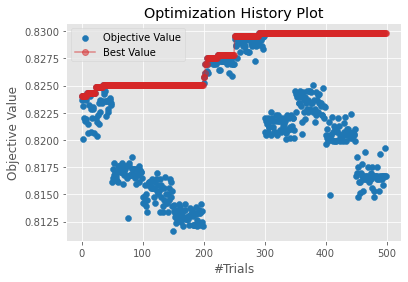

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,204.600000,8.643559
1,TN,169.800000,7.786027
2,FP,43.200000,7.315129
3,FN,31.600000,4.671426
4,Accuracy,0.833475,0.016882
5,Precision,0.825907,0.027157
6,Sensitivity,0.866218,0.019091
7,Specificity,0.797510,0.030660
8,F1 score,0.845272,0.016761
9,F1 score (weighted),0.833124,0.017016


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,396.000000,403.000000,405.000000,419.000000,395.000000,389.000000,407.000000,399.000000,413.000000,421.000000,404.700000,10.520351
1,TN,343.000000,352.000000,344.000000,336.000000,350.000000,341.000000,329.000000,349.000000,337.000000,330.000000,341.100000,8.061569
2,FP,91.000000,91.000000,80.000000,93.000000,101.000000,92.000000,100.000000,89.000000,77.000000,75.000000,88.900000,8.937437
3,FN,69.000000,53.000000,70.000000,51.000000,53.000000,77.000000,63.000000,62.000000,72.000000,73.000000,64.300000,9.369573
4,Accuracy,0.822024,0.839822,0.833148,0.839822,0.828699,0.812013,0.818687,0.832036,0.834260,0.835373,0.829588,0.009244
5,Precision,0.813142,0.815789,0.835052,0.818359,0.796371,0.808732,0.802761,0.817623,0.842857,0.848790,0.819948,0.017106
6,Sensitivity,0.851613,0.883772,0.852632,0.891489,0.881696,0.834764,0.865957,0.865510,0.851546,0.852227,0.863121,0.017917
7,Specificity,0.790300,0.794600,0.811300,0.783200,0.776100,0.787500,0.766900,0.796800,0.814000,0.814800,0.793550,0.016212
8,F1 score,0.831933,0.848421,0.843750,0.853360,0.836864,0.821542,0.833163,0.840885,0.847179,0.850505,0.840760,0.009904
9,F1 score (weighted),0.821767,0.839437,0.833021,0.839125,0.828240,0.811845,0.818035,0.831754,0.834182,0.835335,0.829274,0.009243


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)



Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=1121218, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
   
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_rf)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
    
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_rf))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_rf))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_rf))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_rf))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_rf, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_rf, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_rf))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_rf))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_rf))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
rf_5preds = pd.concat([rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4487,4487,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4488,4488,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4489,4489,0.0,1.0,1.0,1.0,1.0,0.0,0.8,0.4
4490,4490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
rf_5preds.to_csv('rf_5test_CV_result.csv')
mat_met_optimized_rf.to_csv('mat_met_rf_opt.csv')

In [39]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_clf, X, Y, cv=10, scoring="f1_macro")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="f1_macro")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="f1_macro")
print("RF baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model f1_score 0.8308 with a standard deviation of 0.0278
RF optimized model f1_score 0.8319 with a standard deviation of 0.0263


In [40]:
import joblib
joblib.dump(rf_clf, "./rf_clf.joblib")
#joblib.dump(optimized_rf, "./optimized_rf.joblib") # fitted to whole training set with last random_state selected
joblib.dump(optimizedCV_rf, "./optimizedCV_rf_clf.joblib")

['./optimizedCV_rf_clf.joblib']

## LGBMclassifier

In [41]:
%%time

TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_clf = lgbm.LGBMClassifier(
        objective="binary",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=8,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_clf.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="logloss",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_clf.predict(X_test) 
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    TP       200.100000     8.900062
1                    TN       171.300000     8.819801
2                    FP        41.700000     8.353974
3                    FN        36.100000     6.100091
4              Accuracy         0.826796     0.017186
5             Precision         0.828134     0.029879
6           Sensitivity         0.847234     0.024678
7           Specificity         0.804550     0.036179
8              F1 score         0.837065     0.017148
9   F1 score (weighted)         0.826599     0.017334
10     F1 score (macro)         0.825881     0.017294
11    Balanced Accuracy         0.825895     0.017280
12                  MCC         0.653159     0.033713
13                  NPV         0.826410     0.023653
14              ROC_AUC         0.825895     0.017280
CPU times: user 18.9 s, sys: 132 ms, total: 19.1 s
Wall time: 2.53 s


In [42]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
       
        
    return np.mean(cv_scores)

In [43]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        
    }
    
    
  
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        
        y_pred = lgbm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [44]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="LGBMClassifier")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:16:51,655] A new study created in memory with name: LGBMClassifier
[I 2023-02-17 12:16:54,549] Trial 0 finished with value: 0.8216017717901994 and parameters: {'n_estimators': 264, 'learning_rate': 0.08850344354416637, 'max_depth': 7, 'max_bin': 164, 'num_leaves': 651}. Best is trial 0 with value: 0.8216017717901994.
[I 2023-02-17 12:16:56,611] Trial 1 finished with value: 0.8126155176367084 and parameters: {'n_estimators': 103, 'learning_rate': 0.16354430242488383, 'max_depth': 10, 'max_bin': 271, 'num_leaves': 632}. Best is trial 0 with value: 0.8216017717901994.
[I 2023-02-17 12:16:58,399] Trial 2 finished with value: 0.7998107946277385 and parameters: {'n_estimators': 64, 'learning_rate': 0.05758706851045406, 'max_depth': 11, 'max_bin': 270, 'num_leaves': 618}. Best is trial 0 with value: 0.8216017717901994.
[I 2023-02-17 12:17:00,874] Trial 3 finished with value: 0.8151716971945243 and parameters: {'n_estimators': 710, 'learning_rate': 0.1831564217006419, 'max_dep

[I 2023-02-17 12:19:19,790] Trial 31 finished with value: 0.8189919439583381 and parameters: {'n_estimators': 238, 'learning_rate': 0.03805414406390006, 'max_depth': 12, 'max_bin': 240, 'num_leaves': 133}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:19:23,160] Trial 32 finished with value: 0.8183918147554584 and parameters: {'n_estimators': 432, 'learning_rate': 0.09418086494176878, 'max_depth': 12, 'max_bin': 258, 'num_leaves': 85}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:19:30,171] Trial 33 finished with value: 0.8199249783839202 and parameters: {'n_estimators': 402, 'learning_rate': 0.019343972166720593, 'max_depth': 11, 'max_bin': 249, 'num_leaves': 156}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:19:32,821] Trial 34 finished with value: 0.8175131294391763 and parameters: {'n_estimators': 475, 'learning_rate': 0.15400969019068744, 'max_depth': 12, 'max_bin': 217, 'num_leaves': 227}. Best is trial 23 with value: 

	Number of trials: 50.0
	Best value (f1_score): 0.8296
	Best params:
		n_estimators: 615
		learning_rate: 0.0404096120295208
		max_depth: 10
		max_bin: 226
		num_leaves: 157


In [45]:
optimized_lgbm_0 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_lgbm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_lgbm_0)
Precision = precision_score(Y_testSet0, y_pred_lgbm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_lgbm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_lgbm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_lgbm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_lgbm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_lgbm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_lgbm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_lgbm_0)


mat_met_lgbm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    TP  385.000000
1                    TN  356.000000
2                    FP   78.000000
3                    FN   80.000000
4              Accuracy    0.824249
5             Precision    0.831533
6           Sensitivity    0.827957
7           Specificity    0.820300
8              F1 score    0.829741
9   F1 score (weighted)    0.824262
10     F1 score (macro)    0.824066
11    Balanced Accuracy    0.824117
12                  MCC    0.648140
13                  NPV    0.816500
14              ROC_AUC    0.824117


In [46]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:21:40,976] Trial 50 finished with value: 0.7934046637409444 and parameters: {'n_estimators': 893, 'learning_rate': 0.011373365748957972, 'max_depth': 5, 'max_bin': 167, 'num_leaves': 440}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:21:46,386] Trial 51 finished with value: 0.8277198649289886 and parameters: {'n_estimators': 438, 'learning_rate': 0.04306271350544206, 'max_depth': 12, 'max_bin': 244, 'num_leaves': 361}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:21:54,530] Trial 52 finished with value: 0.8214645679092044 and parameters: {'n_estimators': 461, 'learning_rate': 0.020281424820927017, 'max_depth': 11, 'max_bin': 274, 'num_leaves': 382}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:22:00,770] Trial 53 finished with value: 0.8236564283305796 and parameters: {'n_estimators': 501, 'learning_rate': 0.03819445028112902, 'max_depth': 12, 'max_bin': 222, 'num_leaves': 697}. Best is trial 23 with value:

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

[I 2023-02-17 12:24:22,764] Trial 79 finished with value: 0.7890589316690784 and parameters: {'n_estimators': 61, 'learning_rate': 0.04558256263333112, 'max_depth': 12, 'max_bin': 237, 'num_leaves': 31}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:24:25,225] Trial 80 finished with value: 0.7889636192229045 and parameters: {'n_estimators': 423, 'learning_rate': 0.054357819867670965, 'max_depth': 3, 'max_bin': 206, 'num_leaves': 423}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:24:30,833] Trial 81 finished with value: 0.8220743968390718 and parameters: {'n_estimators': 403, 'learning_rate': 0.039292406646017214, 'max_depth': 12, 'max_bin': 262, 'num_leaves': 103}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:24:36,111] Trial 82 finished with value: 0.8207455338918417 and parameters: {'n_estimators': 383, 'learning_rate': 0.04325719575602448, 'max_depth': 12, 'max_bin': 227, 'num_leaves': 76}. Best is trial 23 with value: 0.

	Number of trials: 100.0
	Best value (f1_score): 0.8296
	Best params:
		n_estimators: 615
		learning_rate: 0.0404096120295208
		max_depth: 10
		max_bin: 226
		num_leaves: 157


In [47]:
optimized_lgbm_1 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_lgbm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_lgbm_1)
Precision = precision_score(Y_testSet1, y_pred_lgbm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_lgbm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_lgbm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_lgbm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_lgbm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_lgbm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_lgbm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_lgbm_1)


set1 = pd.DataFrame({ 'Set1':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    TP  385.000000  395.000000
1                    TN  356.000000  364.000000
2                    FP   78.000000   79.000000
3                    FN   80.000000   61.000000
4              Accuracy    0.824249    0.844271
5             Precision    0.831533    0.833333
6           Sensitivity    0.827957    0.866228
7           Specificity    0.820300    0.821700
8              F1 score    0.829741    0.849462
9   F1 score (weighted)    0.824262    0.844164
10     F1 score (macro)    0.824066    0.844086
11    Balanced Accuracy    0.824117    0.843949
12                  MCC    0.648140    0.688851
13                  NPV    0.816500    0.856500
14              ROC_AUC    0.824117    0.843949


In [48]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:27:14,098] Trial 100 finished with value: 0.8238697953207883 and parameters: {'n_estimators': 745, 'learning_rate': 0.019691406190368778, 'max_depth': 11, 'max_bin': 261, 'num_leaves': 506}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:27:22,794] Trial 101 finished with value: 0.8237039010648809 and parameters: {'n_estimators': 818, 'learning_rate': 0.025679654069702802, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 418}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:27:29,436] Trial 102 finished with value: 0.821806489978723 and parameters: {'n_estimators': 366, 'learning_rate': 0.03138360166925416, 'max_depth': 12, 'max_bin': 236, 'num_leaves': 446}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:27:35,421] Trial 103 finished with value: 0.8270517496970425 and parameters: {'n_estimators': 686, 'learning_rate': 0.04456297921089894, 'max_depth': 12, 'max_bin': 248, 'num_leaves': 529}. Best is trial 23 with va

[I 2023-02-17 12:29:49,727] Trial 131 finished with value: 0.8265289063916557 and parameters: {'n_estimators': 662, 'learning_rate': 0.06751541860482858, 'max_depth': 10, 'max_bin': 252, 'num_leaves': 632}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:29:55,037] Trial 132 finished with value: 0.8244065590507622 and parameters: {'n_estimators': 655, 'learning_rate': 0.05450671094775163, 'max_depth': 10, 'max_bin': 253, 'num_leaves': 662}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:29:59,960] Trial 133 finished with value: 0.8276243771814681 and parameters: {'n_estimators': 636, 'learning_rate': 0.061556024534686324, 'max_depth': 10, 'max_bin': 255, 'num_leaves': 634}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:30:04,805] Trial 134 finished with value: 0.8220894677902676 and parameters: {'n_estimators': 592, 'learning_rate': 0.06253807579131138, 'max_depth': 10, 'max_bin': 258, 'num_leaves': 634}. Best is trial 23 with va

	Number of trials: 150.0
	Best value (f1_score): 0.8296
	Best params:
		n_estimators: 615
		learning_rate: 0.0404096120295208
		max_depth: 10
		max_bin: 226
		num_leaves: 157


In [49]:
optimized_lgbm_2 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_lgbm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_lgbm_2)
Precision = precision_score(Y_testSet2, y_pred_lgbm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_lgbm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_lgbm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_lgbm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_lgbm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_lgbm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_lgbm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_lgbm_2)


Set2 = pd.DataFrame({ 'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    TP  385.000000  395.000000  403.000000
1                    TN  356.000000  364.000000  345.000000
2                    FP   78.000000   79.000000   79.000000
3                    FN   80.000000   61.000000   72.000000
4              Accuracy    0.824249    0.844271    0.832036
5             Precision    0.831533    0.833333    0.836100
6           Sensitivity    0.827957    0.866228    0.848421
7           Specificity    0.820300    0.821700    0.813700
8              F1 score    0.829741    0.849462    0.842215
9   F1 score (weighted)    0.824262    0.844164    0.831951
10     F1 score (macro)    0.824066    0.844086    0.831334
11    Balanced Accuracy    0.824117    0.843949    0.831050
12                  MCC    0.648140    0.688851    0.662769
13                  NPV    0.816500    0.856500    0.827300
14              ROC_AUC    0.824117    0.843949    0.831050


In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:31:24,979] Trial 150 finished with value: 0.8141648189078493 and parameters: {'n_estimators': 602, 'learning_rate': 0.04131941522198379, 'max_depth': 9, 'max_bin': 235, 'num_leaves': 557}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:31:30,931] Trial 151 finished with value: 0.8175450768250269 and parameters: {'n_estimators': 633, 'learning_rate': 0.0394971376234668, 'max_depth': 9, 'max_bin': 232, 'num_leaves': 578}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:31:36,371] Trial 152 finished with value: 0.8184639360505841 and parameters: {'n_estimators': 644, 'learning_rate': 0.04434453862519874, 'max_depth': 9, 'max_bin': 239, 'num_leaves': 550}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:31:42,277] Trial 153 finished with value: 0.8108149927227013 and parameters: {'n_estimators': 681, 'learning_rate': 0.03859929055193981, 'max_depth': 9, 'max_bin': 230, 'num_leaves': 521}. Best is trial 23 with value: 0

[I 2023-02-17 12:33:49,861] Trial 181 finished with value: 0.8129090040876429 and parameters: {'n_estimators': 621, 'learning_rate': 0.06736324762299081, 'max_depth': 9, 'max_bin': 251, 'num_leaves': 661}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:33:54,263] Trial 182 finished with value: 0.8123710342348864 and parameters: {'n_estimators': 659, 'learning_rate': 0.06427982766790369, 'max_depth': 9, 'max_bin': 276, 'num_leaves': 670}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:33:58,921] Trial 183 finished with value: 0.8154123052848163 and parameters: {'n_estimators': 676, 'learning_rate': 0.06140317207599322, 'max_depth': 9, 'max_bin': 250, 'num_leaves': 684}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:34:02,968] Trial 184 finished with value: 0.8159069557058789 and parameters: {'n_estimators': 646, 'learning_rate': 0.05820780179667307, 'max_depth': 8, 'max_bin': 245, 'num_leaves': 616}. Best is trial 23 with value: 

	Number of trials: 200.0
	Best value (f1_score): 0.8296
	Best params:
		n_estimators: 615
		learning_rate: 0.0404096120295208
		max_depth: 10
		max_bin: 226
		num_leaves: 157


In [51]:
optimized_lgbm_3 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_lgbm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_lgbm_3)
Precision = precision_score(Y_testSet3, y_pred_lgbm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_lgbm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_lgbm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_lgbm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_lgbm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_lgbm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_lgbm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_lgbm_3)


Set3 = pd.DataFrame({ 'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  385.000000  395.000000  403.000000  397.000000
1                    TN  356.000000  364.000000  345.000000  351.000000
2                    FP   78.000000   79.000000   79.000000   78.000000
3                    FN   80.000000   61.000000   72.000000   73.000000
4              Accuracy    0.824249    0.844271    0.832036    0.832036
5             Precision    0.831533    0.833333    0.836100    0.835789
6           Sensitivity    0.827957    0.866228    0.848421    0.844681
7           Specificity    0.820300    0.821700    0.813700    0.818200
8              F1 score    0.829741    0.849462    0.842215    0.840212
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431
12                  MCC    0.648140    0.688851    0.662769    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:35:23,134] Trial 200 finished with value: 0.826197952327206 and parameters: {'n_estimators': 666, 'learning_rate': 0.058286898149226864, 'max_depth': 10, 'max_bin': 202, 'num_leaves': 72}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:35:34,298] Trial 201 finished with value: 0.8186348411948211 and parameters: {'n_estimators': 610, 'learning_rate': 0.011618548812107367, 'max_depth': 11, 'max_bin': 274, 'num_leaves': 498}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:35:45,243] Trial 202 finished with value: 0.8290250875105762 and parameters: {'n_estimators': 644, 'learning_rate': 0.015114100122304956, 'max_depth': 11, 'max_bin': 246, 'num_leaves': 603}. Best is trial 23 with value: 0.8295934115345324.
[I 2023-02-17 12:35:58,727] Trial 203 finished with value: 0.8116039424246226 and parameters: {'n_estimators': 645, 'learning_rate': 0.004935064297741789, 'max_depth': 11, 'max_bin': 245, 'num_leaves': 604}. Best is trial 23 with v

[I 2023-02-17 12:41:05,523] Trial 231 finished with value: 0.8276860270971451 and parameters: {'n_estimators': 594, 'learning_rate': 0.01923404039998886, 'max_depth': 12, 'max_bin': 243, 'num_leaves': 608}. Best is trial 206 with value: 0.8331890017437669.
[I 2023-02-17 12:41:14,104] Trial 232 finished with value: 0.8310572234444216 and parameters: {'n_estimators': 597, 'learning_rate': 0.02577726450647322, 'max_depth': 12, 'max_bin': 242, 'num_leaves': 605}. Best is trial 206 with value: 0.8331890017437669.
[I 2023-02-17 12:41:22,419] Trial 233 finished with value: 0.8187562242040818 and parameters: {'n_estimators': 597, 'learning_rate': 0.024212313870370754, 'max_depth': 12, 'max_bin': 244, 'num_leaves': 608}. Best is trial 206 with value: 0.8331890017437669.
[I 2023-02-17 12:41:31,828] Trial 234 finished with value: 0.8262112286685401 and parameters: {'n_estimators': 619, 'learning_rate': 0.020204774783479304, 'max_depth': 12, 'max_bin': 241, 'num_leaves': 606}. Best is trial 206 wi

	Number of trials: 250.0
	Best value (f1_score): 0.8332
	Best params:
		n_estimators: 574
		learning_rate: 0.01793932177679684
		max_depth: 12
		max_bin: 237
		num_leaves: 580


In [53]:
optimized_lgbm_4 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_lgbm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_lgbm_4)
Precision = precision_score(Y_testSet4, y_pred_lgbm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_lgbm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_lgbm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_lgbm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_lgbm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_lgbm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_lgbm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_lgbm_4)


Set4 = pd.DataFrame({ 'Set4':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  395.000000  403.000000  397.000000   
1                    TN  356.000000  364.000000  345.000000  351.000000   
2                    FP   78.000000   79.000000   79.000000   78.000000   
3                    FN   80.000000   61.000000   72.000000   73.000000   
4              Accuracy    0.824249    0.844271    0.832036    0.832036   
5             Precision    0.831533    0.833333    0.836100    0.835789   
6           Sensitivity    0.827957    0.866228    0.848421    0.844681   
7           Specificity    0.820300    0.821700    0.813700    0.818200   
8              F1 score    0.829741    0.849462    0.842215    0.840212   
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988   
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595   
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431   
12                  MCC  

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:44:05,429] Trial 250 finished with value: 0.8247197855512953 and parameters: {'n_estimators': 634, 'learning_rate': 0.011389650311090734, 'max_depth': 12, 'max_bin': 246, 'num_leaves': 613}. Best is trial 206 with value: 0.8331890017437669.
[I 2023-02-17 12:44:14,257] Trial 251 finished with value: 0.8305056340227205 and parameters: {'n_estimators': 623, 'learning_rate': 0.02856352309048336, 'max_depth': 12, 'max_bin': 242, 'num_leaves': 570}. Best is trial 206 with value: 0.8331890017437669.
[I 2023-02-17 12:44:22,362] Trial 252 finished with value: 0.8310093352481216 and parameters: {'n_estimators': 596, 'learning_rate': 0.029611722423206095, 'max_depth': 12, 'max_bin': 240, 'num_leaves': 571}. Best is trial 206 with value: 0.8331890017437669.
[I 2023-02-17 12:44:31,182] Trial 253 finished with value: 0.8265257956733949 and parameters: {'n_estimators': 593, 'learning_rate': 0.027457488511874878, 'max_depth': 12, 'max_bin': 239, 'num_leaves': 573}. Best is trial 206 w

[I 2023-02-17 12:47:54,570] Trial 281 finished with value: 0.8308046555042565 and parameters: {'n_estimators': 471, 'learning_rate': 0.03733334759606042, 'max_depth': 12, 'max_bin': 221, 'num_leaves': 500}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:48:01,196] Trial 282 finished with value: 0.8319134269566847 and parameters: {'n_estimators': 474, 'learning_rate': 0.0373666582972166, 'max_depth': 12, 'max_bin': 221, 'num_leaves': 499}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:48:07,943] Trial 283 finished with value: 0.8302366638830708 and parameters: {'n_estimators': 464, 'learning_rate': 0.03716080512042523, 'max_depth': 12, 'max_bin': 220, 'num_leaves': 500}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:48:14,702] Trial 284 finished with value: 0.8313339189762946 and parameters: {'n_estimators': 464, 'learning_rate': 0.037739469254944195, 'max_depth': 12, 'max_bin': 220, 'num_leaves': 499}. Best is trial 280 with

	Number of trials: 300.0
	Best value (f1_score): 0.8364
	Best params:
		n_estimators: 474
		learning_rate: 0.03748850514767109
		max_depth: 12
		max_bin: 220
		num_leaves: 494


In [55]:
optimized_lgbm_5 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_lgbm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_lgbm_5)
Precision = precision_score(Y_testSet5, y_pred_lgbm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_lgbm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_lgbm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_lgbm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_lgbm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_lgbm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_lgbm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_lgbm_5)


Set5 = pd.DataFrame({ 'Set5':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  395.000000  403.000000  397.000000   
1                    TN  356.000000  364.000000  345.000000  351.000000   
2                    FP   78.000000   79.000000   79.000000   78.000000   
3                    FN   80.000000   61.000000   72.000000   73.000000   
4              Accuracy    0.824249    0.844271    0.832036    0.832036   
5             Precision    0.831533    0.833333    0.836100    0.835789   
6           Sensitivity    0.827957    0.866228    0.848421    0.844681   
7           Specificity    0.820300    0.821700    0.813700    0.818200   
8              F1 score    0.829741    0.849462    0.842215    0.840212   
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988   
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595   
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431   
12                  MCC  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:50:00,499] Trial 300 finished with value: 0.8294555961915402 and parameters: {'n_estimators': 453, 'learning_rate': 0.04395691519076264, 'max_depth': 12, 'max_bin': 217, 'num_leaves': 486}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:50:06,709] Trial 301 finished with value: 0.8315261796154889 and parameters: {'n_estimators': 485, 'learning_rate': 0.03967220540444852, 'max_depth': 12, 'max_bin': 208, 'num_leaves': 468}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:50:12,811] Trial 302 finished with value: 0.8280672301109882 and parameters: {'n_estimators': 479, 'learning_rate': 0.03956457523504514, 'max_depth': 12, 'max_bin': 212, 'num_leaves': 458}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:50:19,134] Trial 303 finished with value: 0.8269062522482397 and parameters: {'n_estimators': 433, 'learning_rate': 0.04411425588058844, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 441}. Best is trial 280 with

[I 2023-02-17 12:53:09,020] Trial 331 finished with value: 0.828740818230381 and parameters: {'n_estimators': 489, 'learning_rate': 0.03184851802452236, 'max_depth': 12, 'max_bin': 204, 'num_leaves': 482}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:53:15,628] Trial 332 finished with value: 0.8287555473706988 and parameters: {'n_estimators': 465, 'learning_rate': 0.0366401074059391, 'max_depth': 12, 'max_bin': 220, 'num_leaves': 522}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:53:21,634] Trial 333 finished with value: 0.8301365640181153 and parameters: {'n_estimators': 446, 'learning_rate': 0.04240892549314043, 'max_depth': 12, 'max_bin': 223, 'num_leaves': 472}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:53:28,793] Trial 334 finished with value: 0.8326672825311935 and parameters: {'n_estimators': 422, 'learning_rate': 0.030307734659916707, 'max_depth': 11, 'max_bin': 217, 'num_leaves': 499}. Best is trial 280 with 

	Number of trials: 350.0
	Best value (f1_score): 0.836434
	Best params:
		n_estimators: 474
		learning_rate: 0.03748850514767109
		max_depth: 12
		max_bin: 220
		num_leaves: 494


In [57]:
optimized_lgbm_6 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_lgbm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_lgbm_6)
Precision = precision_score(Y_testSet6, y_pred_lgbm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_lgbm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_lgbm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_lgbm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_lgbm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_lgbm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_lgbm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_lgbm_6)


Set6 = pd.DataFrame({ 'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  395.000000  403.000000  397.000000   
1                    TN  356.000000  364.000000  345.000000  351.000000   
2                    FP   78.000000   79.000000   79.000000   78.000000   
3                    FN   80.000000   61.000000   72.000000   73.000000   
4              Accuracy    0.824249    0.844271    0.832036    0.832036   
5             Precision    0.831533    0.833333    0.836100    0.835789   
6           Sensitivity    0.827957    0.866228    0.848421    0.844681   
7           Specificity    0.820300    0.821700    0.813700    0.818200   
8              F1 score    0.829741    0.849462    0.842215    0.840212   
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988   
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595   
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431   
12                  MCC  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:55:19,570] Trial 350 finished with value: 0.8263173197772401 and parameters: {'n_estimators': 457, 'learning_rate': 0.028729222147240597, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 479}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:55:26,988] Trial 351 finished with value: 0.8263339275464372 and parameters: {'n_estimators': 439, 'learning_rate': 0.02560307124096945, 'max_depth': 12, 'max_bin': 218, 'num_leaves': 432}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:55:34,535] Trial 352 finished with value: 0.8250752801091525 and parameters: {'n_estimators': 464, 'learning_rate': 0.02820624276857278, 'max_depth': 12, 'max_bin': 224, 'num_leaves': 507}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:55:41,019] Trial 353 finished with value: 0.8260671906201835 and parameters: {'n_estimators': 403, 'learning_rate': 0.033102974259251815, 'max_depth': 12, 'max_bin': 219, 'num_leaves': 459}. Best is trial 280 wi

[I 2023-02-17 12:58:21,661] Trial 381 finished with value: 0.8217572193852387 and parameters: {'n_estimators': 468, 'learning_rate': 0.04511335976895585, 'max_depth': 12, 'max_bin': 216, 'num_leaves': 498}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:58:28,538] Trial 382 finished with value: 0.8247627805931149 and parameters: {'n_estimators': 443, 'learning_rate': 0.03427426137166921, 'max_depth': 12, 'max_bin': 220, 'num_leaves': 520}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:58:34,315] Trial 383 finished with value: 0.8256663743931577 and parameters: {'n_estimators': 397, 'learning_rate': 0.04009617249425578, 'max_depth': 12, 'max_bin': 223, 'num_leaves': 429}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 12:58:41,656] Trial 384 finished with value: 0.8296673118046669 and parameters: {'n_estimators': 496, 'learning_rate': 0.02900068242450993, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 545}. Best is trial 280 with

	Number of trials: 400.0
	Best value (f1_score): 0.8364344
	Best params:
		n_estimators: 474
		learning_rate: 0.03748850514767109
		max_depth: 12
		max_bin: 220
		num_leaves: 494


In [59]:
optimized_lgbm_7 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_lgbm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_lgbm_7)
Precision = precision_score(Y_testSet7, y_pred_lgbm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_lgbm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_lgbm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_lgbm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_lgbm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_lgbm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_lgbm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_lgbm_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  395.000000  403.000000  397.000000   
1                    TN  356.000000  364.000000  345.000000  351.000000   
2                    FP   78.000000   79.000000   79.000000   78.000000   
3                    FN   80.000000   61.000000   72.000000   73.000000   
4              Accuracy    0.824249    0.844271    0.832036    0.832036   
5             Precision    0.831533    0.833333    0.836100    0.835789   
6           Sensitivity    0.827957    0.866228    0.848421    0.844681   
7           Specificity    0.820300    0.821700    0.813700    0.818200   
8              F1 score    0.829741    0.849462    0.842215    0.840212   
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988   
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595   
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431   
12                  MCC  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:00:22,973] Trial 400 finished with value: 0.8208291732219761 and parameters: {'n_estimators': 469, 'learning_rate': 0.02666576342235808, 'max_depth': 12, 'max_bin': 192, 'num_leaves': 510}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:00:29,120] Trial 401 finished with value: 0.821594658028286 and parameters: {'n_estimators': 453, 'learning_rate': 0.038657641672780345, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 545}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:00:35,350] Trial 402 finished with value: 0.826451188390503 and parameters: {'n_estimators': 491, 'learning_rate': 0.04151870953066344, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 467}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:00:42,376] Trial 403 finished with value: 0.8219313543063986 and parameters: {'n_estimators': 430, 'learning_rate': 0.03068464533104851, 'max_depth': 12, 'max_bin': 219, 'num_leaves': 497}. Best is trial 280 with 

[I 2023-02-17 13:03:48,425] Trial 431 finished with value: 0.8224109415443156 and parameters: {'n_estimators': 478, 'learning_rate': 0.031587192498685426, 'max_depth': 12, 'max_bin': 214, 'num_leaves': 548}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:03:55,801] Trial 432 finished with value: 0.8198738801247594 and parameters: {'n_estimators': 406, 'learning_rate': 0.026871006558585403, 'max_depth': 12, 'max_bin': 208, 'num_leaves': 439}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:04:02,368] Trial 433 finished with value: 0.8213491325875465 and parameters: {'n_estimators': 463, 'learning_rate': 0.035423714302257554, 'max_depth': 12, 'max_bin': 226, 'num_leaves': 528}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:04:07,904] Trial 434 finished with value: 0.8242108291390036 and parameters: {'n_estimators': 281, 'learning_rate': 0.039646916027548836, 'max_depth': 12, 'max_bin': 222, 'num_leaves': 475}. Best is trial 280 

	Number of trials: 450.0
	Best value (f1_score): 0.83643443
	Best params:
		n_estimators: 474
		learning_rate: 0.03748850514767109
		max_depth: 12
		max_bin: 220
		num_leaves: 494


In [61]:
optimized_lgbm_8 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_lgbm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_lgbm_8)
Precision = precision_score(Y_testSet8, y_pred_lgbm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_lgbm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_lgbm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_lgbm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_lgbm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_lgbm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_lgbm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_lgbm_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  395.000000  403.000000  397.000000   
1                    TN  356.000000  364.000000  345.000000  351.000000   
2                    FP   78.000000   79.000000   79.000000   78.000000   
3                    FN   80.000000   61.000000   72.000000   73.000000   
4              Accuracy    0.824249    0.844271    0.832036    0.832036   
5             Precision    0.831533    0.833333    0.836100    0.835789   
6           Sensitivity    0.827957    0.866228    0.848421    0.844681   
7           Specificity    0.820300    0.821700    0.813700    0.818200   
8              F1 score    0.829741    0.849462    0.842215    0.840212   
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988   
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595   
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431   
12                  MCC  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:05:51,834] Trial 450 finished with value: 0.8203408085545011 and parameters: {'n_estimators': 404, 'learning_rate': 0.030033822839003004, 'max_depth': 12, 'max_bin': 234, 'num_leaves': 468}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:05:57,542] Trial 451 finished with value: 0.8263296132826479 and parameters: {'n_estimators': 510, 'learning_rate': 0.04488845610419008, 'max_depth': 12, 'max_bin': 219, 'num_leaves': 552}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:06:03,942] Trial 452 finished with value: 0.8247480244619915 and parameters: {'n_estimators': 557, 'learning_rate': 0.03468940860534335, 'max_depth': 12, 'max_bin': 228, 'num_leaves': 523}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:06:10,096] Trial 453 finished with value: 0.8253027620632827 and parameters: {'n_estimators': 438, 'learning_rate': 0.0384971120625381, 'max_depth': 12, 'max_bin': 212, 'num_leaves': 448}. Best is trial 280 with

[I 2023-02-17 13:09:03,558] Trial 481 finished with value: 0.8227566755738188 and parameters: {'n_estimators': 470, 'learning_rate': 0.03941058323181005, 'max_depth': 12, 'max_bin': 225, 'num_leaves': 405}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:09:09,797] Trial 482 finished with value: 0.8247519331872777 and parameters: {'n_estimators': 400, 'learning_rate': 0.04314498226593491, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 512}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:09:15,276] Trial 483 finished with value: 0.8242068654519666 and parameters: {'n_estimators': 485, 'learning_rate': 0.04947983826960449, 'max_depth': 12, 'max_bin': 216, 'num_leaves': 487}. Best is trial 280 with value: 0.8364344323727007.
[I 2023-02-17 13:09:22,555] Trial 484 finished with value: 0.8214677606328215 and parameters: {'n_estimators': 455, 'learning_rate': 0.030948118180082914, 'max_depth': 12, 'max_bin': 220, 'num_leaves': 526}. Best is trial 280 wit

	Number of trials: 500.0
	Best value (f1_score): 0.836434432
	Best params:
		n_estimators: 474
		learning_rate: 0.03748850514767109
		max_depth: 12
		max_bin: 220
		num_leaves: 494


In [63]:
optimized_lgbm_9 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_lgbm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_lgbm_9)
Precision = precision_score(Y_testSet9, y_pred_lgbm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_lgbm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_lgbm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_lgbm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_lgbm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_lgbm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_lgbm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_lgbm_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  395.000000  403.000000  397.000000   
1                    TN  356.000000  364.000000  345.000000  351.000000   
2                    FP   78.000000   79.000000   79.000000   78.000000   
3                    FN   80.000000   61.000000   72.000000   73.000000   
4              Accuracy    0.824249    0.844271    0.832036    0.832036   
5             Precision    0.831533    0.833333    0.836100    0.835789   
6           Sensitivity    0.827957    0.866228    0.848421    0.844681   
7           Specificity    0.820300    0.821700    0.813700    0.818200   
8              F1 score    0.829741    0.849462    0.842215    0.840212   
9   F1 score (weighted)    0.824262    0.844164    0.831951    0.831988   
10     F1 score (macro)    0.824066    0.844086    0.831334    0.831595   
11    Balanced Accuracy    0.824117    0.843949    0.831050    0.831431   
12                  MCC  

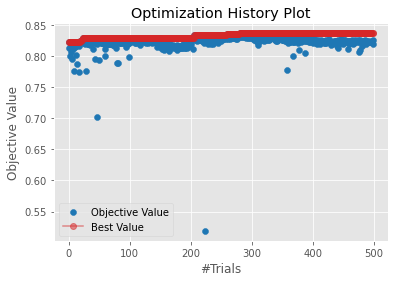

In [64]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

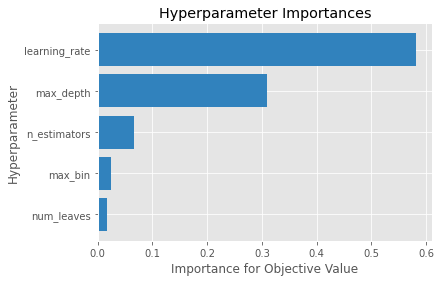

In [65]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [66]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    TP       200.500000     7.863417
1                    TN       173.700000     7.746684
2                    FP        39.300000     7.498889
3                    FN        35.700000     6.412661
4              Accuracy         0.833029     0.013778
5             Precision         0.836643     0.026819
6           Sensitivity         0.849101     0.024874
7           Specificity         0.815870     0.031662
8              F1 score         0.842295     0.013846
9   F1 score (weighted)         0.832914     0.013876
10     F1 score (macro)         0.832276     0.013886
11    Balanced Accuracy         0.832491     0.013743
12                  MCC         0.665820     0.026769
13                  NPV         0.830020     0.024923
14              ROC_AUC         0.832491     0.013743


In [67]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,385.000000,395.000000,403.000000,397.000000,394.000000,384.000000,405.000000,388.000000,411.000000,417.000000,397.900000,11.029758
1,TN,356.000000,364.000000,345.000000,351.000000,352.000000,350.000000,342.000000,353.000000,356.000000,334.000000,350.300000,8.340663
2,FP,78.000000,79.000000,79.000000,78.000000,99.000000,83.000000,87.000000,85.000000,58.000000,71.000000,79.700000,10.635893
3,FN,80.000000,61.000000,72.000000,73.000000,54.000000,82.000000,65.000000,73.000000,74.000000,77.000000,71.100000,8.698020
4,Accuracy,0.824249,0.844271,0.832036,0.832036,0.829811,0.816463,0.830923,0.824249,0.853170,0.835373,0.832258,0.010419
5,Precision,0.831533,0.833333,0.836100,0.835789,0.799189,0.822270,0.823171,0.820296,0.876333,0.854508,0.833252,0.020752
6,Sensitivity,0.827957,0.866228,0.848421,0.844681,0.879464,0.824034,0.861702,0.841649,0.847423,0.844130,0.848569,0.016832
7,Specificity,0.820300,0.821700,0.813700,0.818200,0.780500,0.808300,0.797200,0.805900,0.859900,0.824700,0.815040,0.020628
8,F1 score,0.829741,0.849462,0.842215,0.840212,0.837407,0.823151,0.841996,0.830835,0.861635,0.849287,0.840594,0.011201
9,F1 score (weighted),0.824262,0.844164,0.831951,0.831988,0.829412,0.816455,0.830632,0.824158,0.853331,0.835475,0.832183,0.010468


In [68]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_lgbm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
       
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_lgbm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_lgbm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_lgbm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_lgbm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_lgbm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_lgbm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_lgbm))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
lgbm_5preds = pd.concat([lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.6,0.489898
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4,4,1.0,0.0,0.0,0.0,0.0,1.0,0.2,0.400000
...,...,...,...,...,...,...,...,...,...
4487,4487,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4488,4488,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4489,4489,0.0,1.0,1.0,1.0,0.0,0.0,0.6,0.489898
4490,4490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [69]:
mat_met_optimized_lgbm.to_csv('mat_met_lgbm_opt.csv')
lgbm_5preds.to_csv('lgbm_5test_CV_result.csv')

In [70]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_clf, X, Y, cv=10, scoring="f1_macro")
#f1_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="f1_macro")
f1_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="f1_macro", fit_params=fit_params)
print("LightGBM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)f1_score %0.4f with a standard deviation of %0.4f" % (f1_cv_lgbm_opt_testSet.mean(), f1_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(f1_cv_lgbm_opt), np.std(f1_cv_lgbm_opt, ddof=1)))

LightGBM baseline model f1_score 0.8279 with a standard deviation of 0.0209
LightGBM optimized model f1_score 0.8382 with a standard deviation of 0.0178


In [71]:
joblib.dump(lgbm_clf, "./lgbm_clf.joblib")
#joblib.dump(optimized_lgbm, "./optimized_lgbm.joblib")
joblib.dump(optimizedCV_lgbm, "./optimizedCV_lgbm_clf.joblib") 
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_lgbm_clf.joblib']

## XGBoost

In [72]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    n_jobs=8,
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_clf.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="logloss",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       198.600000     7.676805
1                    TN       172.700000     8.667308
2                    FP        40.300000     7.513691
3                    FN        37.600000     6.850791
4              Accuracy         0.826580     0.017077
5             Precision         0.831862     0.026795
6           Sensitivity         0.841121     0.026473
7           Specificity         0.811020     0.032874
8              F1 score         0.835962     0.015795
9   F1 score (weighted)         0.826489     0.017125
10     F1 score (macro)         0.825826     0.017339
11    Balanced Accuracy         0.826075     0.017323
12                  MCC         0.652805     0.034451
13                  NPV         0.821600     0.028929
14              ROC_AUC         0.826075     0.017323
CPU times: user 16.4 s, sys: 28 ms, total: 16.4 s
Wall time: 2.16 s


In [73]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
            
    return np.mean(cv_scores)

In [74]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [75]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBClassifier")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:12:16,536] A new study created in memory with name: XGBClassifier
[I 2023-02-17 13:12:25,347] Trial 0 finished with value: 0.8260633344675565 and parameters: {'n_estimators': 592, 'eta': 0.0951435752711342, 'max_depth': 9, 'alpha': 0.6576000000000001, 'lambda': 8.55936011157803, 'max_bin': 326}. Best is trial 0 with value: 0.8260633344675565.
[I 2023-02-17 13:12:33,162] Trial 1 finished with value: 0.8282405670010459 and parameters: {'n_estimators': 583, 'eta': 0.09222300921771683, 'max_depth': 12, 'alpha': 0.08080000000000001, 'lambda': 6.575694449891304, 'max_bin': 286}. Best is trial 1 with value: 0.8282405670010459.
[I 2023-02-17 13:12:48,074] Trial 2 finished with value: 0.8308313028219778 and parameters: {'n_estimators': 819, 'eta': 0.02929463830239589, 'max_depth': 11, 'alpha': 0.3521, 'lambda': 2.0667544170372816, 'max_bin': 357}. Best is trial 2 with value: 0.8308313028219778.
[I 2023-02-17 13:12:55,217] Trial 3 finished with value: 0.8125605825437361 and para

[I 2023-02-17 13:18:22,526] Trial 29 finished with value: 0.8226155137006874 and parameters: {'n_estimators': 426, 'eta': 0.09147629082843353, 'max_depth': 6, 'alpha': 0.6441, 'lambda': 11.386952324621648, 'max_bin': 301}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:18:32,981] Trial 30 finished with value: 0.823960914843188 and parameters: {'n_estimators': 568, 'eta': 0.08458391530526192, 'max_depth': 6, 'alpha': 0.7142000000000001, 'lambda': 30.85875759064254, 'max_bin': 327}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:18:41,440] Trial 31 finished with value: 0.8280218915484021 and parameters: {'n_estimators': 749, 'eta': 0.09990915943149106, 'max_depth': 7, 'alpha': 0.5457000000000001, 'lambda': 8.45190388424962, 'max_bin': 368}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:18:53,804] Trial 32 finished with value: 0.8277612873039513 and parameters: {'n_estimators': 863, 'eta': 0.07033665251069161, 'max_depth': 12, 'alpha'

	Number of trials: 50.0
	Best value (f1_score): 0.8331
	Best params:
		n_estimators: 741
		eta: 0.08307189807265311
		max_depth: 10
		alpha: 0.9568000000000001
		lambda: 8.184756243986026
		max_bin: 384


In [76]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

   
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_xgb_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_xgb_0)
Precision = precision_score(Y_testSet0, y_pred_xgb_0)
Sensitivity = recall_score(Y_testSet0, y_pred_xgb_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_xgb_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_xgb_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_xgb_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_xgb_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_xgb_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_xgb_0)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    TP  393.000000
1                    TN  358.000000
2                    FP   76.000000
3                    FN   72.000000
4              Accuracy    0.835373
5             Precision    0.837953
6           Sensitivity    0.845161
7           Specificity    0.824900
8              F1 score    0.841542
9   F1 score (weighted)    0.835344
10     F1 score (macro)    0.835123
11    Balanced Accuracy    0.835023
12                  MCC    0.670279
13                  NPV    0.832600
14              ROC_AUC    0.835023


In [77]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:23:20,792] Trial 50 finished with value: 0.8239802386707419 and parameters: {'n_estimators': 527, 'eta': 0.03897454138682993, 'max_depth': 12, 'alpha': 0.5109, 'lambda': 13.131752137830855, 'max_bin': 369}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:23:38,156] Trial 51 finished with value: 0.8248239452956337 and parameters: {'n_estimators': 719, 'eta': 0.03160399522222444, 'max_depth': 11, 'alpha': 0.22390000000000002, 'lambda': 8.8423322214998, 'max_bin': 318}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:23:51,468] Trial 52 finished with value: 0.8260593698598008 and parameters: {'n_estimators': 891, 'eta': 0.05232706698963962, 'max_depth': 11, 'alpha': 0.1062, 'lambda': 14.975786722230449, 'max_bin': 346}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:24:05,906] Trial 53 finished with value: 0.8251366632491983 and parameters: {'n_estimators': 824, 'eta': 0.044406390952206, 'max_depth': 10, 'alpha': 0.0591,

[I 2023-02-17 13:29:52,470] Trial 79 finished with value: 0.8232056703076015 and parameters: {'n_estimators': 900, 'eta': 0.037273450444507104, 'max_depth': 7, 'alpha': 0.42760000000000004, 'lambda': 2.640314799903607, 'max_bin': 308}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:30:01,054] Trial 80 finished with value: 0.8242133601295709 and parameters: {'n_estimators': 816, 'eta': 0.07396876793675279, 'max_depth': 10, 'alpha': 0.2611, 'lambda': 7.926810686897084, 'max_bin': 332}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:30:15,827] Trial 81 finished with value: 0.8242290006016558 and parameters: {'n_estimators': 706, 'eta': 0.030177465774739252, 'max_depth': 11, 'alpha': 0.31620000000000004, 'lambda': 3.391032790088847, 'max_bin': 354}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:30:44,755] Trial 82 finished with value: 0.8122234798119885 and parameters: {'n_estimators': 859, 'eta': 0.007487820964601703, 'max_depth': 12,

	Number of trials: 100.0
	Best value (f1_score): 0.8331
	Best params:
		n_estimators: 741
		eta: 0.08307189807265311
		max_depth: 10
		alpha: 0.9568000000000001
		lambda: 8.184756243986026
		max_bin: 384


In [78]:
optimized_xgb_1 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_xgb_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_xgb_1)
Precision = precision_score(Y_testSet1, y_pred_xgb_1)
Sensitivity = recall_score(Y_testSet1, y_pred_xgb_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_xgb_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_xgb_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_xgb_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_xgb_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_xgb_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_xgb_1)


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    TP  393.000000  398.000000
1                    TN  358.000000  363.000000
2                    FP   76.000000   80.000000
3                    FN   72.000000   58.000000
4              Accuracy    0.835373    0.846496
5             Precision    0.837953    0.832636
6           Sensitivity    0.845161    0.872807
7           Specificity    0.824900    0.819400
8              F1 score    0.841542    0.852248
9   F1 score (weighted)    0.835344    0.846350
10     F1 score (macro)    0.835123    0.846263
11    Balanced Accuracy    0.835023    0.846110
12                  MCC    0.670279    0.693543
13                  NPV    0.832600    0.862200
14              ROC_AUC    0.835023    0.846110


In [79]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:34:27,723] Trial 100 finished with value: 0.8230806142065152 and parameters: {'n_estimators': 89, 'eta': 0.0535726392698182, 'max_depth': 12, 'alpha': 0.6355000000000001, 'lambda': 1.9366794922650983, 'max_bin': 329}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:34:44,277] Trial 101 finished with value: 0.8290863013625746 and parameters: {'n_estimators': 872, 'eta': 0.04577988535138554, 'max_depth': 11, 'alpha': 0.0912, 'lambda': 15.263039960718803, 'max_bin': 312}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:35:02,706] Trial 102 finished with value: 0.8252276843674871 and parameters: {'n_estimators': 830, 'eta': 0.03671321936950886, 'max_depth': 11, 'alpha': 0.016800000000000002, 'lambda': 15.846361196191928, 'max_bin': 317}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:35:18,221] Trial 103 finished with value: 0.8305274434498487 and parameters: {'n_estimators': 884, 'eta': 0.04249862667064454, 'max_depth': 

[I 2023-02-17 13:42:05,843] Trial 129 finished with value: 0.8269167494165808 and parameters: {'n_estimators': 795, 'eta': 0.03880578532001394, 'max_depth': 12, 'alpha': 0.0443, 'lambda': 3.6865276969444074, 'max_bin': 351}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:42:24,534] Trial 130 finished with value: 0.8274095402872973 and parameters: {'n_estimators': 858, 'eta': 0.03609373406415138, 'max_depth': 11, 'alpha': 0.6994, 'lambda': 11.85925950221487, 'max_bin': 451}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:42:45,736] Trial 131 finished with value: 0.8286771533236061 and parameters: {'n_estimators': 881, 'eta': 0.01915942102434368, 'max_depth': 11, 'alpha': 0.34190000000000004, 'lambda': 2.4663074759877293, 'max_bin': 387}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:43:00,470] Trial 132 finished with value: 0.8187763936294642 and parameters: {'n_estimators': 829, 'eta': 0.01902509034096398, 'max_depth': 6, 'alpha': 

	Number of trials: 150.0
	Best value (f1_score): 0.8331
	Best params:
		n_estimators: 741
		eta: 0.08307189807265311
		max_depth: 10
		alpha: 0.9568000000000001
		lambda: 8.184756243986026
		max_bin: 384


In [80]:
optimized_xgb_2 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_xgb_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_xgb_2)
Precision = precision_score(Y_testSet2, y_pred_xgb_2)
Sensitivity = recall_score(Y_testSet2, y_pred_xgb_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_xgb_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_xgb_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_xgb_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_xgb_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_xgb_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_xgb_2)


Set2 = pd.DataFrame({ 'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    TP  393.000000  398.000000  417.000000
1                    TN  358.000000  363.000000  347.000000
2                    FP   76.000000   80.000000   77.000000
3                    FN   72.000000   58.000000   58.000000
4              Accuracy    0.835373    0.846496    0.849833
5             Precision    0.837953    0.832636    0.844130
6           Sensitivity    0.845161    0.872807    0.877895
7           Specificity    0.824900    0.819400    0.818400
8              F1 score    0.841542    0.852248    0.860681
9   F1 score (weighted)    0.835344    0.846350    0.849585
10     F1 score (macro)    0.835123    0.846263    0.848917
11    Balanced Accuracy    0.835023    0.846110    0.848145
12                  MCC    0.670279    0.693543    0.698601
13                  NPV    0.832600    0.862200    0.856800
14              ROC_AUC    0.835023    0.846110    0.848145


In [81]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:47:14,781] Trial 150 finished with value: 0.8180382668368391 and parameters: {'n_estimators': 687, 'eta': 0.03023483043374211, 'max_depth': 12, 'alpha': 0.38970000000000005, 'lambda': 2.037244107808428, 'max_bin': 306}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:47:28,180] Trial 151 finished with value: 0.8175848963794238 and parameters: {'n_estimators': 735, 'eta': 0.03134320811151156, 'max_depth': 12, 'alpha': 0.3719, 'lambda': 2.9427928353048, 'max_bin': 301}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:47:39,276] Trial 152 finished with value: 0.8191136082252347 and parameters: {'n_estimators': 699, 'eta': 0.03312952519171, 'max_depth': 12, 'alpha': 0.30770000000000003, 'lambda': 1.062494416092752, 'max_bin': 310}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:47:56,587] Trial 153 finished with value: 0.8191813881216905 and parameters: {'n_estimators': 677, 'eta': 0.023560561010238727, 'max_depth': 12, '

[I 2023-02-17 13:53:44,257] Trial 179 finished with value: 0.8202535770468249 and parameters: {'n_estimators': 585, 'eta': 0.06649664905976559, 'max_depth': 12, 'alpha': 0.3214, 'lambda': 2.454392601114922, 'max_bin': 300}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:53:50,752] Trial 180 finished with value: 0.8127890949800067 and parameters: {'n_estimators': 218, 'eta': 0.04501431762914804, 'max_depth': 11, 'alpha': 0.3473, 'lambda': 1.0572972050552443, 'max_bin': 309}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:54:05,669] Trial 181 finished with value: 0.8164177497131793 and parameters: {'n_estimators': 881, 'eta': 0.03932089519392362, 'max_depth': 12, 'alpha': 0.068, 'lambda': 10.067190566043257, 'max_bin': 341}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:54:20,213] Trial 182 finished with value: 0.8201469960839469 and parameters: {'n_estimators': 856, 'eta': 0.04225986507463804, 'max_depth': 12, 'alpha': 0.02890000000

	Number of trials: 200.0
	Best value (f1_score): 0.8331
	Best params:
		n_estimators: 741
		eta: 0.08307189807265311
		max_depth: 10
		alpha: 0.9568000000000001
		lambda: 8.184756243986026
		max_bin: 384


In [82]:
optimized_xgb_3 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_xgb_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_xgb_3)
Precision = precision_score(Y_testSet3, y_pred_xgb_3)
Sensitivity = recall_score(Y_testSet3, y_pred_xgb_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_xgb_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_xgb_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_xgb_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_xgb_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_xgb_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_xgb_3)


Set3 = pd.DataFrame({ 'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  393.000000  398.000000  417.000000  412.000000
1                    TN  358.000000  363.000000  347.000000  346.000000
2                    FP   76.000000   80.000000   77.000000   83.000000
3                    FN   72.000000   58.000000   58.000000   58.000000
4              Accuracy    0.835373    0.846496    0.849833    0.843159
5             Precision    0.837953    0.832636    0.844130    0.832323
6           Sensitivity    0.845161    0.872807    0.877895    0.876596
7           Specificity    0.824900    0.819400    0.818400    0.806500
8              F1 score    0.841542    0.852248    0.860681    0.853886
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561
12                  MCC    0.670279    0.693543    0.698601    0

In [83]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:58:59,583] Trial 200 finished with value: 0.8307468183316464 and parameters: {'n_estimators': 900, 'eta': 0.08057576992633064, 'max_depth': 12, 'alpha': 0.36610000000000004, 'lambda': 7.551225032280977, 'max_bin': 308}. Best is trial 9 with value: 0.8330909770787589.
[I 2023-02-17 13:59:07,577] Trial 201 finished with value: 0.8335373394618 and parameters: {'n_estimators': 898, 'eta': 0.07859686958613045, 'max_depth': 12, 'alpha': 0.37310000000000004, 'lambda': 7.3831978819179325, 'max_bin': 308}. Best is trial 201 with value: 0.8335373394618.
[I 2023-02-17 13:59:15,539] Trial 202 finished with value: 0.833348676150208 and parameters: {'n_estimators': 895, 'eta': 0.07961652296169673, 'max_depth': 12, 'alpha': 0.36910000000000004, 'lambda': 6.940725449801789, 'max_bin': 309}. Best is trial 201 with value: 0.8335373394618.
[I 2023-02-17 13:59:23,569] Trial 203 finished with value: 0.8318481538045572 and parameters: {'n_estimators': 893, 'eta': 0.08054666801594629, 'max_d

[I 2023-02-17 14:02:49,243] Trial 229 finished with value: 0.8341694779654982 and parameters: {'n_estimators': 852, 'eta': 0.07608425320951939, 'max_depth': 12, 'alpha': 0.4567, 'lambda': 6.412317900966858, 'max_bin': 313}. Best is trial 210 with value: 0.8347611586500671.
[I 2023-02-17 14:02:57,197] Trial 230 finished with value: 0.8329783987717576 and parameters: {'n_estimators': 846, 'eta': 0.07620305923917263, 'max_depth': 12, 'alpha': 0.46280000000000004, 'lambda': 6.3935295347259435, 'max_bin': 313}. Best is trial 210 with value: 0.8347611586500671.
[I 2023-02-17 14:03:05,017] Trial 231 finished with value: 0.8298941687497938 and parameters: {'n_estimators': 845, 'eta': 0.07634015309298123, 'max_depth': 12, 'alpha': 0.45180000000000003, 'lambda': 6.510471211689606, 'max_bin': 314}. Best is trial 210 with value: 0.8347611586500671.
[I 2023-02-17 14:03:13,066] Trial 232 finished with value: 0.8292754830411433 and parameters: {'n_estimators': 860, 'eta': 0.07295381800761484, 'max_de

	Number of trials: 250.0
	Best value (f1_score): 0.8348
	Best params:
		n_estimators: 873
		eta: 0.08225145923065898
		max_depth: 12
		alpha: 0.4278
		lambda: 5.910431243078647
		max_bin: 296


In [84]:
optimized_xgb_4 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_xgb_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_xgb_4)
Precision = precision_score(Y_testSet4, y_pred_xgb_4)
Sensitivity = recall_score(Y_testSet4, y_pred_xgb_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_xgb_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_xgb_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_xgb_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_xgb_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_xgb_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_xgb_4)


Set4 = pd.DataFrame({ 'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  393.000000  398.000000  417.000000  412.000000   
1                    TN  358.000000  363.000000  347.000000  346.000000   
2                    FP   76.000000   80.000000   77.000000   83.000000   
3                    FN   72.000000   58.000000   58.000000   58.000000   
4              Accuracy    0.835373    0.846496    0.849833    0.843159   
5             Precision    0.837953    0.832636    0.844130    0.832323   
6           Sensitivity    0.845161    0.872807    0.877895    0.876596   
7           Specificity    0.824900    0.819400    0.818400    0.806500   
8              F1 score    0.841542    0.852248    0.860681    0.853886   
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837   
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309   
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561   
12                  MCC  

In [85]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:05:43,994] Trial 250 finished with value: 0.8359025048349933 and parameters: {'n_estimators': 851, 'eta': 0.0811146584963724, 'max_depth': 12, 'alpha': 0.45830000000000004, 'lambda': 7.1117250074614855, 'max_bin': 315}. Best is trial 250 with value: 0.8359025048349933.
[I 2023-02-17 14:05:52,525] Trial 251 finished with value: 0.8336126423720136 and parameters: {'n_estimators': 845, 'eta': 0.08147055644672636, 'max_depth': 12, 'alpha': 0.4575, 'lambda': 7.950404953338693, 'max_bin': 318}. Best is trial 250 with value: 0.8359025048349933.
[I 2023-02-17 14:06:01,318] Trial 252 finished with value: 0.8346075033587853 and parameters: {'n_estimators': 831, 'eta': 0.0810942780866794, 'max_depth': 12, 'alpha': 0.4792, 'lambda': 7.101325842535345, 'max_bin': 316}. Best is trial 250 with value: 0.8359025048349933.
[I 2023-02-17 14:06:10,083] Trial 253 finished with value: 0.8387114991415864 and parameters: {'n_estimators': 827, 'eta': 0.0823490983362348, 'max_depth': 12, 'alpha

[I 2023-02-17 14:09:54,277] Trial 279 finished with value: 0.8319812089412881 and parameters: {'n_estimators': 799, 'eta': 0.08670594596672673, 'max_depth': 12, 'alpha': 0.44630000000000003, 'lambda': 7.730280781739328, 'max_bin': 318}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:10:03,150] Trial 280 finished with value: 0.8342314184186155 and parameters: {'n_estimators': 823, 'eta': 0.09524551156938785, 'max_depth': 12, 'alpha': 0.4877, 'lambda': 9.787906695394224, 'max_bin': 332}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:10:11,518] Trial 281 finished with value: 0.8343577698958586 and parameters: {'n_estimators': 831, 'eta': 0.09430608468024358, 'max_depth': 12, 'alpha': 0.48650000000000004, 'lambda': 10.46060952647452, 'max_bin': 330}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:10:20,300] Trial 282 finished with value: 0.8337706785102356 and parameters: {'n_estimators': 821, 'eta': 0.0943026801478301, 'max_dept

	Number of trials: 300.0
	Best value (f1_score): 0.8396
	Best params:
		n_estimators: 822
		eta: 0.08701851050696605
		max_depth: 12
		alpha: 0.4616
		lambda: 9.108381395969195
		max_bin: 326


In [86]:
optimized_xgb_5 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_xgb_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_xgb_5)
Precision = precision_score(Y_testSet5, y_pred_xgb_5)
Sensitivity = recall_score(Y_testSet5, y_pred_xgb_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_xgb_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_xgb_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_xgb_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_xgb_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_xgb_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_xgb_5)


Set5 = pd.DataFrame({ 'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  393.000000  398.000000  417.000000  412.000000   
1                    TN  358.000000  363.000000  347.000000  346.000000   
2                    FP   76.000000   80.000000   77.000000   83.000000   
3                    FN   72.000000   58.000000   58.000000   58.000000   
4              Accuracy    0.835373    0.846496    0.849833    0.843159   
5             Precision    0.837953    0.832636    0.844130    0.832323   
6           Sensitivity    0.845161    0.872807    0.877895    0.876596   
7           Specificity    0.824900    0.819400    0.818400    0.806500   
8              F1 score    0.841542    0.852248    0.860681    0.853886   
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837   
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309   
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561   
12                  MCC  

In [87]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:13:03,670] Trial 300 finished with value: 0.8348891893264909 and parameters: {'n_estimators': 758, 'eta': 0.08882433952427383, 'max_depth': 12, 'alpha': 0.6131, 'lambda': 12.36995431751809, 'max_bin': 343}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:13:13,050] Trial 301 finished with value: 0.8320132196680703 and parameters: {'n_estimators': 796, 'eta': 0.08950572461389172, 'max_depth': 12, 'alpha': 0.6089, 'lambda': 13.214835951822735, 'max_bin': 340}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:13:21,709] Trial 302 finished with value: 0.8353574248669122 and parameters: {'n_estimators': 756, 'eta': 0.0884154806437089, 'max_depth': 12, 'alpha': 0.6556000000000001, 'lambda': 11.057140052693253, 'max_bin': 343}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:13:30,650] Trial 303 finished with value: 0.8311452777614615 and parameters: {'n_estimators': 765, 'eta': 0.09276206324174659, 'max_depth': 12, 'alp

[I 2023-02-17 14:17:23,311] Trial 329 finished with value: 0.8316612976373854 and parameters: {'n_estimators': 733, 'eta': 0.09324210474788992, 'max_depth': 12, 'alpha': 0.5542, 'lambda': 10.302201985608948, 'max_bin': 343}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:17:31,741] Trial 330 finished with value: 0.833628667691527 and parameters: {'n_estimators': 806, 'eta': 0.0988316728362902, 'max_depth': 12, 'alpha': 0.606, 'lambda': 11.52274983966618, 'max_bin': 331}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:17:41,160] Trial 331 finished with value: 0.8346272289638199 and parameters: {'n_estimators': 774, 'eta': 0.08770373293739328, 'max_depth': 12, 'alpha': 0.5604, 'lambda': 12.55117329675851, 'max_bin': 351}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:17:49,209] Trial 332 finished with value: 0.8320448205843066 and parameters: {'n_estimators': 793, 'eta': 0.09198957961463798, 'max_depth': 12, 'alpha': 0.5363, 'l

	Number of trials: 350.0
	Best value (f1_score): 0.8396
	Best params:
		n_estimators: 822
		eta: 0.08701851050696605
		max_depth: 12
		alpha: 0.4616
		lambda: 9.108381395969195
		max_bin: 326


In [88]:
optimized_xgb_6 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_xgb_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_xgb_6)
Precision = precision_score(Y_testSet6, y_pred_xgb_6)
Sensitivity = recall_score(Y_testSet6, y_pred_xgb_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_xgb_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_xgb_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_xgb_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_xgb_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_xgb_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_xgb_6)


Set6 = pd.DataFrame({ 'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  393.000000  398.000000  417.000000  412.000000   
1                    TN  358.000000  363.000000  347.000000  346.000000   
2                    FP   76.000000   80.000000   77.000000   83.000000   
3                    FN   72.000000   58.000000   58.000000   58.000000   
4              Accuracy    0.835373    0.846496    0.849833    0.843159   
5             Precision    0.837953    0.832636    0.844130    0.832323   
6           Sensitivity    0.845161    0.872807    0.877895    0.876596   
7           Specificity    0.824900    0.819400    0.818400    0.806500   
8              F1 score    0.841542    0.852248    0.860681    0.853886   
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837   
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309   
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561   
12                  MCC  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:20:28,734] Trial 350 finished with value: 0.8281736526514413 and parameters: {'n_estimators': 785, 'eta': 0.08642941290831353, 'max_depth': 12, 'alpha': 0.5725, 'lambda': 13.047997013338506, 'max_bin': 342}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:20:36,929] Trial 351 finished with value: 0.8273301336740868 and parameters: {'n_estimators': 768, 'eta': 0.08791555256333691, 'max_depth': 12, 'alpha': 0.5863, 'lambda': 13.691385799932831, 'max_bin': 350}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:20:45,712] Trial 352 finished with value: 0.8307112930677418 and parameters: {'n_estimators': 730, 'eta': 0.08378359845121393, 'max_depth': 12, 'alpha': 0.5498000000000001, 'lambda': 12.429195636005186, 'max_bin': 345}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:20:53,071] Trial 353 finished with value: 0.8296121564703492 and parameters: {'n_estimators': 785, 'eta': 0.096096760523859, 'max_depth': 12, 'alp

[I 2023-02-17 14:24:22,363] Trial 379 finished with value: 0.826833916160453 and parameters: {'n_estimators': 760, 'eta': 0.08522784694152535, 'max_depth': 12, 'alpha': 0.44370000000000004, 'lambda': 22.773415245090394, 'max_bin': 333}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:24:30,537] Trial 380 finished with value: 0.8340782140811459 and parameters: {'n_estimators': 809, 'eta': 0.08997966912514294, 'max_depth': 12, 'alpha': 0.7059000000000001, 'lambda': 14.998876850143024, 'max_bin': 348}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:24:38,989] Trial 381 finished with value: 0.8262426736609164 and parameters: {'n_estimators': 798, 'eta': 0.08711884672957673, 'max_depth': 12, 'alpha': 0.6414000000000001, 'lambda': 13.714112964351212, 'max_bin': 328}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:24:46,025] Trial 382 finished with value: 0.8270381534463539 and parameters: {'n_estimators': 723, 'eta': 0.09495610180565

	Number of trials: 400.0
	Best value (f1_score): 0.8396
	Best params:
		n_estimators: 822
		eta: 0.08701851050696605
		max_depth: 12
		alpha: 0.4616
		lambda: 9.108381395969195
		max_bin: 326


In [90]:
optimized_xgb_7 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_xgb_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_xgb_7)
Precision = precision_score(Y_testSet7, y_pred_xgb_7)
Sensitivity = recall_score(Y_testSet7, y_pred_xgb_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_xgb_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_xgb_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_xgb_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_xgb_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_xgb_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_xgb_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  393.000000  398.000000  417.000000  412.000000   
1                    TN  358.000000  363.000000  347.000000  346.000000   
2                    FP   76.000000   80.000000   77.000000   83.000000   
3                    FN   72.000000   58.000000   58.000000   58.000000   
4              Accuracy    0.835373    0.846496    0.849833    0.843159   
5             Precision    0.837953    0.832636    0.844130    0.832323   
6           Sensitivity    0.845161    0.872807    0.877895    0.876596   
7           Specificity    0.824900    0.819400    0.818400    0.806500   
8              F1 score    0.841542    0.852248    0.860681    0.853886   
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837   
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309   
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561   
12                  MCC  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:27:11,106] Trial 400 finished with value: 0.8316606787486698 and parameters: {'n_estimators': 811, 'eta': 0.08710980076637294, 'max_depth': 12, 'alpha': 0.5105000000000001, 'lambda': 10.04695854527425, 'max_bin': 327}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:27:19,925] Trial 401 finished with value: 0.8315190639536771 and parameters: {'n_estimators': 736, 'eta': 0.08341073285869607, 'max_depth': 12, 'alpha': 0.5509000000000001, 'lambda': 8.397683001518448, 'max_bin': 319}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:27:29,222] Trial 402 finished with value: 0.8278416483260994 and parameters: {'n_estimators': 786, 'eta': 0.09044923521372343, 'max_depth': 12, 'alpha': 0.6171, 'lambda': 11.76078616875162, 'max_bin': 336}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:27:36,781] Trial 403 finished with value: 0.8273657432442837 and parameters: {'n_estimators': 819, 'eta': 0.09811274755474063, 'max_depth

[I 2023-02-17 14:31:14,240] Trial 429 finished with value: 0.828461807536103 and parameters: {'n_estimators': 760, 'eta': 0.09998149056303765, 'max_depth': 12, 'alpha': 0.5244, 'lambda': 12.090688366457162, 'max_bin': 343}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:31:22,562] Trial 430 finished with value: 0.8289845095691584 and parameters: {'n_estimators': 823, 'eta': 0.0906078299139348, 'max_depth': 12, 'alpha': 0.5755, 'lambda': 11.095755906831446, 'max_bin': 335}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:31:31,459] Trial 431 finished with value: 0.8304626806922819 and parameters: {'n_estimators': 783, 'eta': 0.09289743857335028, 'max_depth': 9, 'alpha': 0.45, 'lambda': 13.07983822102024, 'max_bin': 322}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:31:39,339] Trial 432 finished with value: 0.8290021570335586 and parameters: {'n_estimators': 806, 'eta': 0.09722271627382112, 'max_depth': 12, 'alpha': 0.492600000

	Number of trials: 450.0
	Best value (f1_score): 0.8396
	Best params:
		n_estimators: 822
		eta: 0.08701851050696605
		max_depth: 12
		alpha: 0.4616
		lambda: 9.108381395969195
		max_bin: 326


In [92]:
optimized_xgb_8 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_xgb_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_xgb_8)
Precision = precision_score(Y_testSet8, y_pred_xgb_8)
Sensitivity = recall_score(Y_testSet8, y_pred_xgb_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_xgb_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_xgb_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_xgb_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_xgb_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_xgb_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_xgb_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  393.000000  398.000000  417.000000  412.000000   
1                    TN  358.000000  363.000000  347.000000  346.000000   
2                    FP   76.000000   80.000000   77.000000   83.000000   
3                    FN   72.000000   58.000000   58.000000   58.000000   
4              Accuracy    0.835373    0.846496    0.849833    0.843159   
5             Precision    0.837953    0.832636    0.844130    0.832323   
6           Sensitivity    0.845161    0.872807    0.877895    0.876596   
7           Specificity    0.824900    0.819400    0.818400    0.806500   
8              F1 score    0.841542    0.852248    0.860681    0.853886   
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837   
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309   
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561   
12                  MCC  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:34:14,945] Trial 450 finished with value: 0.8247980948672298 and parameters: {'n_estimators': 781, 'eta': 0.08569590911058096, 'max_depth': 7, 'alpha': 0.5131, 'lambda': 32.39949482914779, 'max_bin': 406}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:34:23,595] Trial 451 finished with value: 0.8235217300855634 and parameters: {'n_estimators': 754, 'eta': 0.08231926033230899, 'max_depth': 12, 'alpha': 0.4772, 'lambda': 12.237995111294204, 'max_bin': 331}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:34:31,059] Trial 452 finished with value: 0.82695747629929 and parameters: {'n_estimators': 806, 'eta': 0.09183734573564266, 'max_depth': 12, 'alpha': 0.44580000000000003, 'lambda': 8.26801295629074, 'max_bin': 350}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:34:38,940] Trial 453 finished with value: 0.8288529567072358 and parameters: {'n_estimators': 831, 'eta': 0.09824739242934884, 'max_depth': 12, 'alpha'

[I 2023-02-17 14:37:54,876] Trial 478 finished with value: 0.8300086598408283 and parameters: {'n_estimators': 802, 'eta': 0.09242172994821, 'max_depth': 12, 'alpha': 0.5716, 'lambda': 11.329070976981171, 'max_bin': 326}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:38:06,436] Trial 479 finished with value: 0.8283170938379023 and parameters: {'n_estimators': 819, 'eta': 0.05732613953722297, 'max_depth': 12, 'alpha': 0.5134000000000001, 'lambda': 12.78435889111594, 'max_bin': 259}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:38:13,785] Trial 480 finished with value: 0.829621140887474 and parameters: {'n_estimators': 786, 'eta': 0.08883969583643209, 'max_depth': 12, 'alpha': 0.42650000000000005, 'lambda': 9.586551095930005, 'max_bin': 335}. Best is trial 261 with value: 0.8396177830633036.
[I 2023-02-17 14:38:21,524] Trial 481 finished with value: 0.8266493885253041 and parameters: {'n_estimators': 767, 'eta': 0.08642424437470063, 'max_depth':

	Number of trials: 500.0
	Best value (f1_score): 0.8396
	Best params:
		n_estimators: 822
		eta: 0.08701851050696605
		max_depth: 12
		alpha: 0.4616
		lambda: 9.108381395969195
		max_bin: 326


In [94]:
optimized_xgb_9 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_xgb_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_xgb_9)
Precision = precision_score(Y_testSet9, y_pred_xgb_9)
Sensitivity = recall_score(Y_testSet9, y_pred_xgb_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_xgb_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_xgb_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_xgb_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_xgb_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_xgb_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_xgb_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  393.000000  398.000000  417.000000  412.000000   
1                    TN  358.000000  363.000000  347.000000  346.000000   
2                    FP   76.000000   80.000000   77.000000   83.000000   
3                    FN   72.000000   58.000000   58.000000   58.000000   
4              Accuracy    0.835373    0.846496    0.849833    0.843159   
5             Precision    0.837953    0.832636    0.844130    0.832323   
6           Sensitivity    0.845161    0.872807    0.877895    0.876596   
7           Specificity    0.824900    0.819400    0.818400    0.806500   
8              F1 score    0.841542    0.852248    0.860681    0.853886   
9   F1 score (weighted)    0.835344    0.846350    0.849585    0.842837   
10     F1 score (macro)    0.835123    0.846263    0.848917    0.842309   
11    Balanced Accuracy    0.835023    0.846110    0.848145    0.841561   
12                  MCC  

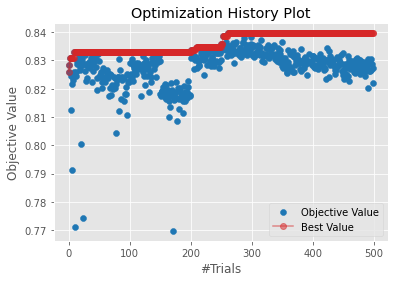

In [95]:
plot_optimization_history(study_xgb);

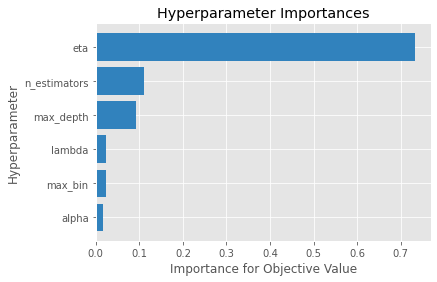

In [96]:
plot_param_importances(study_xgb);

In [97]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,204.500000,5.930149
1,TN,174.000000,9.104334
2,FP,39.000000,8.653837
3,FN,31.700000,6.600505
4,Accuracy,0.842606,0.014768
5,Precision,0.840770,0.029839
6,Sensitivity,0.866291,0.024475
7,Specificity,0.817240,0.037863
8,F1 score,0.852690,0.012290
9,F1 score (weighted),0.842383,0.014941


In [98]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,393.000000,398.000000,417.000000,412.000000,400.000000,395.000000,414.000000,402.000000,424.000000,420.000000,407.500000,11.177855
1,TN,358.000000,363.000000,347.000000,346.000000,348.000000,352.000000,341.000000,346.000000,348.000000,328.000000,347.700000,9.416888
2,FP,76.000000,80.000000,77.000000,83.000000,103.000000,81.000000,88.000000,92.000000,66.000000,77.000000,82.300000,10.133004
3,FN,72.000000,58.000000,58.000000,58.000000,48.000000,71.000000,56.000000,59.000000,61.000000,74.000000,61.500000,8.249579
4,Accuracy,0.835373,0.846496,0.849833,0.843159,0.832036,0.830923,0.839822,0.832036,0.858732,0.832036,0.840044,0.009392
5,Precision,0.837953,0.832636,0.844130,0.832323,0.795229,0.829832,0.824701,0.813765,0.865306,0.845070,0.832095,0.018873
6,Sensitivity,0.845161,0.872807,0.877895,0.876596,0.892857,0.847639,0.880851,0.872017,0.874227,0.850202,0.869025,0.015900
7,Specificity,0.824900,0.819400,0.818400,0.806500,0.771600,0.812900,0.794900,0.790000,0.840600,0.809900,0.808910,0.019518
8,F1 score,0.841542,0.852248,0.860681,0.853886,0.841220,0.838641,0.851852,0.841885,0.869744,0.847629,0.849933,0.009869
9,F1 score (weighted),0.835344,0.846350,0.849585,0.842837,0.831439,0.830833,0.839356,0.831650,0.858665,0.831978,0.839804,0.009438


In [99]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["logloss"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_xgb)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_xgb))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_xgb))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_xgb))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_xgb))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_xgb))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_xgb))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_xgb))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
xgb_5preds = pd.concat([xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4,4,1.0,0.0,0.0,1.0,0.0,0.0,0.2,0.400000
...,...,...,...,...,...,...,...,...,...
4487,4487,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4488,4488,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4489,4489,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.400000
4490,4490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [100]:
mat_met_optimized_xgb.to_csv('mat_met_xgb_opt.csv')
xgb_5preds.to_csv('xgb_5test_CV_result.csv')

In [101]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_clf, X, Y, cv=10, scoring="f1_macro", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
print("XGBoost baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

[14:42:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [102]:
joblib.dump(xgb_clf, "./xgb_clf.joblib")
#joblib.dump(optimized_xgb, "./optimized_xgb.joblib")
joblib.dump(optimizedCV_xgb, "./optimizedCV_xgb_clf.joblib")


['./optimizedCV_xgb_clf.joblib']

## KNeighbors (KNN)

In [103]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_clf = KNeighborsClassifier()
    
    knn_clf.fit(X_train,y_train)

    y_pred = knn_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       197.400000     9.559172
1                    TN       169.200000    10.612362
2                    FP        43.800000     9.425733
3                    FN        38.800000     6.892830
4              Accuracy         0.816115     0.015921
5             Precision         0.819460     0.030795
6           Sensitivity         0.835778     0.028490
7           Specificity         0.794510     0.042712
8              F1 score         0.826811     0.015336
9   F1 score (weighted)         0.815843     0.016221
10     F1 score (macro)         0.815062     0.016419
11    Balanced Accuracy         0.815149     0.016671
12                  MCC         0.631940     0.031574
13                  NPV         0.814150     0.024311
14              ROC_AUC         0.815149     0.016671
CPU times: user 21.5 s, sys: 4 ms, total: 21.5 s
Wall time: 21.5 s


In [104]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)

In [105]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),      
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [106]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNClassifier")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:42:56,980] A new study created in memory with name: KNNClassifier
[I 2023-02-17 14:43:00,034] Trial 0 finished with value: 0.7692126983239562 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 89}. Best is trial 0 with value: 0.7692126983239562.
[I 2023-02-17 14:43:03,125] Trial 1 finished with value: 0.7585872343519913 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 95}. Best is trial 0 with value: 0.7692126983239562.
[I 2023-02-17 14:43:06,761] Trial 2 finished with value: 0.7619091149780555 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 0 with value: 0.7692126983239562.
[I 2023-02-17 14:43:10,374] Trial 3 finished with value: 0.7810035840817872 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 44}. Best is trial 3 with value: 0.7810035840817872.
[I 2023-02-17 14:43:14,8

[I 2023-02-17 14:44:49,553] Trial 35 finished with value: 0.8072705364833259 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 8 with value: 0.8104536596864254.
[I 2023-02-17 14:44:52,546] Trial 36 finished with value: 0.802453728906471 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 62}. Best is trial 8 with value: 0.8104536596864254.
[I 2023-02-17 14:44:56,219] Trial 37 finished with value: 0.8098967269508073 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 36}. Best is trial 8 with value: 0.8104536596864254.
[I 2023-02-17 14:44:59,238] Trial 38 finished with value: 0.7960260288620165 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 77}. Best is trial 8 with value: 0.8104536596864254.
[I 2023-02-17 14:45:02,934] Trial 39 finished with value: 0.785759018376547 and parameters: {'n_neighbor

	Number of trials: 50.0
	Best value (f1_score): 0.8150
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 64


In [107]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# predict
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_knn_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_knn_0)
Precision = precision_score(Y_testSet0, y_pred_knn_0)
Sensitivity = recall_score(Y_testSet0, y_pred_knn_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_knn_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_knn_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_knn_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_knn_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_knn_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_knn_0)
    

mat_met_knn_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    TP  385.000000
1                    TN  350.000000
2                    FP   84.000000
3                    FN   80.000000
4              Accuracy    0.817575
5             Precision    0.820896
6           Sensitivity    0.827957
7           Specificity    0.806500
8              F1 score    0.824411
9   F1 score (weighted)    0.817543
10     F1 score (macro)    0.817298
11    Balanced Accuracy    0.817204
12                  MCC    0.634629
13                  NPV    0.814000
14              ROC_AUC    0.817204


In [108]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:45:37,205] Trial 50 finished with value: 0.776685611765544 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 99}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:45:40,119] Trial 51 finished with value: 0.814944868103338 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:45:43,034] Trial 52 finished with value: 0.814944868103338 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:45:45,920] Trial 53 finished with value: 0.8127864783570565 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:45:48,863] Trial 54 finished with value: 0.814944868103338 and parameters: {'n_neighb

[I 2023-02-17 14:47:19,978] Trial 85 finished with value: 0.814944868103338 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:47:22,852] Trial 86 finished with value: 0.8085211851263802 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 84}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:47:25,696] Trial 87 finished with value: 0.8124132800973205 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 94}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:47:28,614] Trial 88 finished with value: 0.8080455440771237 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 91}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:47:31,615] Trial 89 finished with value: 0.8072591235241158 and parameters: {'n_neig

	Number of trials: 100.0
	Best value (f1_score): 0.8150
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 64


In [109]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# predict
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_knn_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_knn_1)
Precision = precision_score(Y_testSet1, y_pred_knn_1)
Sensitivity = recall_score(Y_testSet1, y_pred_knn_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_knn_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_knn_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_knn_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_knn_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_knn_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_knn_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    TP  385.000000  389.000000
1                    TN  350.000000  350.000000
2                    FP   84.000000   93.000000
3                    FN   80.000000   67.000000
4              Accuracy    0.817575    0.822024
5             Precision    0.820896    0.807054
6           Sensitivity    0.827957    0.853070
7           Specificity    0.806500    0.790100
8              F1 score    0.824411    0.829424
9   F1 score (weighted)    0.817543    0.821801
10     F1 score (macro)    0.817298    0.821689
11    Balanced Accuracy    0.817204    0.821569
12                  MCC    0.634629    0.644758
13                  NPV    0.814000    0.839300
14              ROC_AUC    0.817204    0.821569


In [110]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:48:05,819] Trial 100 finished with value: 0.8117705189975244 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 94}. Best is trial 43 with value: 0.8150073404039212.
[I 2023-02-17 14:48:08,714] Trial 101 finished with value: 0.8165803003134405 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 89}. Best is trial 101 with value: 0.8165803003134405.
[I 2023-02-17 14:48:11,626] Trial 102 finished with value: 0.8165803003134405 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 101 with value: 0.8165803003134405.
[I 2023-02-17 14:48:14,693] Trial 103 finished with value: 0.8117858851797047 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 101 with value: 0.8165803003134405.
[I 2023-02-17 14:48:17,818] Trial 104 finished with value: 0.8074065040466127 and parameters:

[I 2023-02-17 14:50:05,089] Trial 135 finished with value: 0.8079238235388141 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 22}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:50:08,579] Trial 136 finished with value: 0.8185397156694855 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 26}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:50:13,089] Trial 137 finished with value: 0.8065927897111467 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 25}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:50:17,577] Trial 138 finished with value: 0.8079238235388141 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 20}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:50:21,212] Trial 139 finished with value: 0.8185397156694855 and parameters:

	Number of trials: 150.0
	Best value (f1_score): 0.8188
	Best params:
		n_neighbors: 6
		weights: distance
		metric: minkowski
		leaf_size: 96


In [111]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )
#predict
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_knn_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_knn_2)
Precision = precision_score(Y_testSet2, y_pred_knn_2)
Sensitivity = recall_score(Y_testSet2, y_pred_knn_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_knn_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_knn_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_knn_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_knn_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_knn_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_knn_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    TP  385.000000  389.000000  386.000000
1                    TN  350.000000  350.000000  341.000000
2                    FP   84.000000   93.000000   83.000000
3                    FN   80.000000   67.000000   89.000000
4              Accuracy    0.817575    0.822024    0.808676
5             Precision    0.820896    0.807054    0.823028
6           Sensitivity    0.827957    0.853070    0.812632
7           Specificity    0.806500    0.790100    0.804200
8              F1 score    0.824411    0.829424    0.817797
9   F1 score (weighted)    0.817543    0.821801    0.808740
10     F1 score (macro)    0.817298    0.821689    0.808196
11    Balanced Accuracy    0.817204    0.821569    0.808438
12                  MCC    0.634629    0.644758    0.616464
13                  NPV    0.814000    0.839300    0.793000
14              ROC_AUC    0.817204    0.821569    0.808438


In [112]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:51:03,355] Trial 150 finished with value: 0.7855410540228824 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 27}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:51:07,606] Trial 151 finished with value: 0.8146895153989157 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 25}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:51:11,120] Trial 152 finished with value: 0.8152426263779494 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 37}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:51:14,604] Trial 153 finished with value: 0.7958294095683748 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 28}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:51:18,841] Trial 154 finished with value: 0.8146895153989157 and parameter

[I 2023-02-17 14:53:14,913] Trial 185 finished with value: 0.8019171640134992 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 32}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:53:18,289] Trial 186 finished with value: 0.7958294095683748 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 27}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:53:22,575] Trial 187 finished with value: 0.7963235422665447 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 22}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:53:25,974] Trial 188 finished with value: 0.8152426263779494 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 29}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:53:30,319] Trial 189 finished with value: 0.8030597716771919 and parameters

	Number of trials: 200.0
	Best value (f1_score): 0.8188
	Best params:
		n_neighbors: 6
		weights: distance
		metric: minkowski
		leaf_size: 96


In [113]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# predict
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_knn_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_knn_3)
Precision = precision_score(Y_testSet3, y_pred_knn_3)
Sensitivity = recall_score(Y_testSet3, y_pred_knn_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_knn_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_knn_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_knn_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_knn_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_knn_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_knn_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  385.000000  389.000000  386.000000  405.000000
1                    TN  350.000000  350.000000  341.000000  340.000000
2                    FP   84.000000   93.000000   83.000000   89.000000
3                    FN   80.000000   67.000000   89.000000   65.000000
4              Accuracy    0.817575    0.822024    0.808676    0.828699
5             Precision    0.820896    0.807054    0.823028    0.819838
6           Sensitivity    0.827957    0.853070    0.812632    0.861702
7           Specificity    0.806500    0.790100    0.804200    0.792500
8              F1 score    0.824411    0.829424    0.817797    0.840249
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121
12                  MCC    0.634629    0.644758    0.616464    0

In [114]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:54:09,896] Trial 200 finished with value: 0.807816218210565 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 26}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:54:12,841] Trial 201 finished with value: 0.8167409524517943 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 94}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:54:15,774] Trial 202 finished with value: 0.8167409524517943 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 93}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:54:18,733] Trial 203 finished with value: 0.8167409524517943 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 95}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:54:21,725] Trial 204 finished with value: 0.8162560035000341 and parameters:

[I 2023-02-17 14:56:01,932] Trial 235 finished with value: 0.807816218210565 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 26}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:56:05,243] Trial 236 finished with value: 0.8162373557135438 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 31}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:56:08,477] Trial 237 finished with value: 0.8170002543130718 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 30}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:56:11,760] Trial 238 finished with value: 0.7976662438642981 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 28}. Best is trial 106 with value: 0.8188488317295033.
[I 2023-02-17 14:56:15,137] Trial 239 finished with value: 0.7964537875994547 and parameters

	Number of trials: 250.0
	Best value (f1_score): 0.8188
	Best params:
		n_neighbors: 6
		weights: distance
		metric: minkowski
		leaf_size: 96


In [115]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# predict
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_knn_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_knn_4)
Precision = precision_score(Y_testSet4, y_pred_knn_4)
Sensitivity = recall_score(Y_testSet4, y_pred_knn_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_knn_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_knn_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_knn_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_knn_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_knn_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_knn_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  389.000000  386.000000  405.000000   
1                    TN  350.000000  350.000000  341.000000  340.000000   
2                    FP   84.000000   93.000000   83.000000   89.000000   
3                    FN   80.000000   67.000000   89.000000   65.000000   
4              Accuracy    0.817575    0.822024    0.808676    0.828699   
5             Precision    0.820896    0.807054    0.823028    0.819838   
6           Sensitivity    0.827957    0.853070    0.812632    0.861702   
7           Specificity    0.806500    0.790100    0.804200    0.792500   
8              F1 score    0.824411    0.829424    0.817797    0.840249   
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366   
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798   
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121   
12                  MCC  

In [116]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:56:55,408] Trial 250 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 32}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:56:58,762] Trial 251 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 32}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:57:02,187] Trial 252 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 36}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:57:05,676] Trial 253 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:57:09,288] Trial 254 finished with value: 0.8144635169644013 and parameters

[I 2023-02-17 14:58:56,568] Trial 285 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 42}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:58:59,980] Trial 286 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:59:03,456] Trial 287 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 46}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:59:06,875] Trial 288 finished with value: 0.8190194057010226 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 42}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:59:10,350] Trial 289 finished with value: 0.8190194057010226 and parameters

	Number of trials: 300.0
	Best value (f1_score): 0.8190
	Best params:
		n_neighbors: 5
		weights: distance
		metric: minkowski
		leaf_size: 32


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# predict
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_knn_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_knn_5)
Precision = precision_score(Y_testSet5, y_pred_knn_5)
Sensitivity = recall_score(Y_testSet5, y_pred_knn_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_knn_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_knn_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_knn_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_knn_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_knn_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_knn_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  389.000000  386.000000  405.000000   
1                    TN  350.000000  350.000000  341.000000  340.000000   
2                    FP   84.000000   93.000000   83.000000   89.000000   
3                    FN   80.000000   67.000000   89.000000   65.000000   
4              Accuracy    0.817575    0.822024    0.808676    0.828699   
5             Precision    0.820896    0.807054    0.823028    0.819838   
6           Sensitivity    0.827957    0.853070    0.812632    0.861702   
7           Specificity    0.806500    0.790100    0.804200    0.792500   
8              F1 score    0.824411    0.829424    0.817797    0.840249   
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366   
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798   
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121   
12                  MCC  

In [118]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:59:48,514] Trial 300 finished with value: 0.8060453820869883 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 40}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:59:51,898] Trial 301 finished with value: 0.8105346882338418 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:59:55,190] Trial 302 finished with value: 0.8105346882338418 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 14:59:58,557] Trial 303 finished with value: 0.8105346882338418 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:00:01,899] Trial 304 finished with value: 0.8105346882338418 and parameters:

[I 2023-02-17 15:01:49,014] Trial 335 finished with value: 0.8105346882338418 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 38}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:01:52,315] Trial 336 finished with value: 0.7929136725348949 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 34}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:01:55,645] Trial 337 finished with value: 0.7845581685365792 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:01:58,926] Trial 338 finished with value: 0.7798034673854415 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 49}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:02:02,244] Trial 339 finished with value: 0.8060453820869883 and paramet

	Number of trials: 350.0
	Best value (f1_score): 0.8190
	Best params:
		n_neighbors: 5
		weights: distance
		metric: minkowski
		leaf_size: 32


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# predict
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_knn_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_knn_6)
Precision = precision_score(Y_testSet6, y_pred_knn_6)
Sensitivity = recall_score(Y_testSet6, y_pred_knn_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_knn_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_knn_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_knn_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_knn_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_knn_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_knn_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  389.000000  386.000000  405.000000   
1                    TN  350.000000  350.000000  341.000000  340.000000   
2                    FP   84.000000   93.000000   83.000000   89.000000   
3                    FN   80.000000   67.000000   89.000000   65.000000   
4              Accuracy    0.817575    0.822024    0.808676    0.828699   
5             Precision    0.820896    0.807054    0.823028    0.819838   
6           Sensitivity    0.827957    0.853070    0.812632    0.861702   
7           Specificity    0.806500    0.790100    0.804200    0.792500   
8              F1 score    0.824411    0.829424    0.817797    0.840249   
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366   
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798   
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121   
12                  MCC  

In [120]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 15:02:40,315] Trial 350 finished with value: 0.813407511868651 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 45}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:02:43,870] Trial 351 finished with value: 0.7899187715679732 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 42}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:02:47,301] Trial 352 finished with value: 0.8154568589532895 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 47}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:02:50,713] Trial 353 finished with value: 0.813407511868651 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 39}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:02:54,172] Trial 354 finished with value: 0.8154568589532895 and parameters:

[I 2023-02-17 15:04:43,819] Trial 385 finished with value: 0.813407511868651 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 50}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:04:47,315] Trial 386 finished with value: 0.8154568589532895 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:04:50,847] Trial 387 finished with value: 0.813407511868651 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 40}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:04:54,425] Trial 388 finished with value: 0.813407511868651 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 47}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:04:57,915] Trial 389 finished with value: 0.813407511868651 and parameters: {'

	Number of trials: 400.0
	Best value (f1_score): 0.8190
	Best params:
		n_neighbors: 5
		weights: distance
		metric: minkowski
		leaf_size: 32


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# predict
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_knn_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_knn_7)
Precision = precision_score(Y_testSet7, y_pred_knn_7)
Sensitivity = recall_score(Y_testSet7, y_pred_knn_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_knn_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_knn_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_knn_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_knn_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_knn_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_knn_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  389.000000  386.000000  405.000000   
1                    TN  350.000000  350.000000  341.000000  340.000000   
2                    FP   84.000000   93.000000   83.000000   89.000000   
3                    FN   80.000000   67.000000   89.000000   65.000000   
4              Accuracy    0.817575    0.822024    0.808676    0.828699   
5             Precision    0.820896    0.807054    0.823028    0.819838   
6           Sensitivity    0.827957    0.853070    0.812632    0.861702   
7           Specificity    0.806500    0.790100    0.804200    0.792500   
8              F1 score    0.824411    0.829424    0.817797    0.840249   
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366   
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798   
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121   
12                  MCC  

In [122]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 15:05:37,411] Trial 400 finished with value: 0.8055839930353444 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:05:40,737] Trial 401 finished with value: 0.8100340030336397 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 44}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:05:44,089] Trial 402 finished with value: 0.8055839930353444 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 43}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:05:47,432] Trial 403 finished with value: 0.8055839930353444 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:05:50,759] Trial 404 finished with value: 0.8100340030336397 and parameters

[I 2023-02-17 15:07:37,246] Trial 435 finished with value: 0.7930420875533678 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 44}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:07:40,846] Trial 436 finished with value: 0.8055839930353444 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 39}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:07:44,350] Trial 437 finished with value: 0.778863855632811 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 43}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:07:47,749] Trial 438 finished with value: 0.8055839930353444 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:07:51,256] Trial 439 finished with value: 0.8100340030336397 and parameters:

	Number of trials: 450.0
	Best value (f1_score): 0.8190
	Best params:
		n_neighbors: 5
		weights: distance
		metric: minkowski
		leaf_size: 32


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# predict
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_knn_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_knn_8)
Precision = precision_score(Y_testSet8, y_pred_knn_8)
Sensitivity = recall_score(Y_testSet8, y_pred_knn_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_knn_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_knn_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_knn_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_knn_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_knn_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_knn_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  389.000000  386.000000  405.000000   
1                    TN  350.000000  350.000000  341.000000  340.000000   
2                    FP   84.000000   93.000000   83.000000   89.000000   
3                    FN   80.000000   67.000000   89.000000   65.000000   
4              Accuracy    0.817575    0.822024    0.808676    0.828699   
5             Precision    0.820896    0.807054    0.823028    0.819838   
6           Sensitivity    0.827957    0.853070    0.812632    0.861702   
7           Specificity    0.806500    0.790100    0.804200    0.792500   
8              F1 score    0.824411    0.829424    0.817797    0.840249   
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366   
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798   
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121   
12                  MCC  

In [124]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 15:08:29,572] Trial 450 finished with value: 0.8036511479856191 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 33}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:08:32,838] Trial 451 finished with value: 0.8077522246323617 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:08:36,395] Trial 452 finished with value: 0.8036511479856191 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 39}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:08:39,970] Trial 453 finished with value: 0.7896899693196122 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 44}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:08:43,609] Trial 454 finished with value: 0.7618861582245471 and parameter

[I 2023-02-17 15:10:28,483] Trial 485 finished with value: 0.8036511479856191 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:10:31,828] Trial 486 finished with value: 0.8036511479856191 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 41}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:10:35,132] Trial 487 finished with value: 0.8077522246323617 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 38}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:10:38,472] Trial 488 finished with value: 0.8036511479856191 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 50}. Best is trial 250 with value: 0.8190194057010226.
[I 2023-02-17 15:10:41,831] Trial 489 finished with value: 0.8077522246323617 and parameters

	Number of trials: 500.0
	Best value (f1_score): 0.8190
	Best params:
		n_neighbors: 5
		weights: distance
		metric: minkowski
		leaf_size: 32


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# predict
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_knn_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_knn_9)
Precision = precision_score(Y_testSet9, y_pred_knn_9)
Sensitivity = recall_score(Y_testSet9, y_pred_knn_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_knn_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_knn_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_knn_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_knn_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_knn_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_knn_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  385.000000  389.000000  386.000000  405.000000   
1                    TN  350.000000  350.000000  341.000000  340.000000   
2                    FP   84.000000   93.000000   83.000000   89.000000   
3                    FN   80.000000   67.000000   89.000000   65.000000   
4              Accuracy    0.817575    0.822024    0.808676    0.828699   
5             Precision    0.820896    0.807054    0.823028    0.819838   
6           Sensitivity    0.827957    0.853070    0.812632    0.861702   
7           Specificity    0.806500    0.790100    0.804200    0.792500   
8              F1 score    0.824411    0.829424    0.817797    0.840249   
9   F1 score (weighted)    0.817543    0.821801    0.808740    0.828366   
10     F1 score (macro)    0.817298    0.821689    0.808196    0.827798   
11    Balanced Accuracy    0.817204    0.821569    0.808438    0.827121   
12                  MCC  

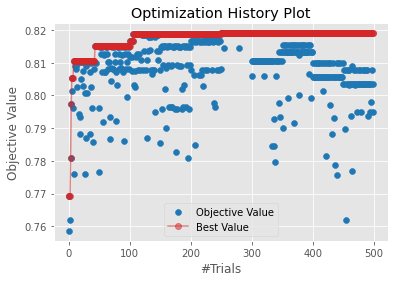

In [126]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

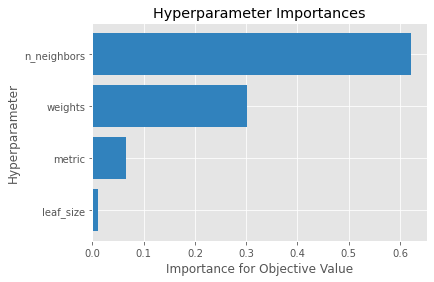

In [127]:

plot_param_importances(study_knn);

In [128]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,197.700000,9.672986
1,TN,171.200000,9.402127
2,FP,41.800000,8.664102
3,FN,38.500000,6.186904
4,Accuracy,0.821234,0.015189
5,Precision,0.826236,0.030217
6,Sensitivity,0.836954,0.025808
7,Specificity,0.804010,0.038189
8,F1 score,0.830960,0.015891
9,F1 score (weighted),0.821060,0.015347


In [129]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,385.000000,389.000000,386.000000,405.000000,390.000000,376.000000,396.000000,384.000000,409.000000,410.000000,393.000000,11.575837
1,TN,350.000000,350.000000,341.000000,340.000000,341.000000,343.000000,332.000000,341.000000,345.000000,325.000000,340.800000,7.598245
2,FP,84.000000,93.000000,83.000000,89.000000,110.000000,90.000000,97.000000,97.000000,69.000000,80.000000,89.200000,11.193252
3,FN,80.000000,67.000000,89.000000,65.000000,58.000000,90.000000,74.000000,77.000000,76.000000,84.000000,76.000000,10.413666
4,Accuracy,0.817575,0.822024,0.808676,0.828699,0.813126,0.799778,0.809789,0.806452,0.838710,0.817575,0.816240,0.011414
5,Precision,0.820896,0.807054,0.823028,0.819838,0.780000,0.806867,0.803245,0.798337,0.855649,0.836735,0.815165,0.021127
6,Sensitivity,0.827957,0.853070,0.812632,0.861702,0.870536,0.806867,0.842553,0.832972,0.843299,0.829960,0.838155,0.020275
7,Specificity,0.806500,0.790100,0.804200,0.792500,0.756100,0.792100,0.773900,0.778500,0.833300,0.802500,0.792970,0.020998
8,F1 score,0.824411,0.829424,0.817797,0.840249,0.822785,0.806867,0.822430,0.815287,0.849429,0.833333,0.826201,0.012431
9,F1 score (weighted),0.817543,0.821801,0.808740,0.828366,0.812535,0.799778,0.809440,0.806245,0.838800,0.817653,0.816090,0.011438


In [130]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_knn)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_knn))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_knn))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_knn))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_knn))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_knn, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_knn, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_knn))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_knn))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_knn))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
knn_5preds = pd.concat([knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4487,4487,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4488,4488,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4489,4489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4490,4490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
mat_met_optimized_knn.to_csv('mat_met_knn_opt.csv')
knn_5preds.to_csv('knn_5test_CV_result.csv')

In [132]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_clf, X, Y, cv=10, scoring="f1_macro")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="f1_macro")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="f1_macro")
print("KNN baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model f1_score 0.8176 with a standard deviation of 0.0186
KNN optimized model f1_score 0.8201 with a standard deviation of 0.0172


In [133]:
joblib.dump(knn_clf, "./knn_clf.joblib")
#joblib.dump(optimized_knn, "./optimized_knn.joblib")
joblib.dump(optimizedCV_knn, "./optimizedCV_knn_clf.joblib")
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_knn_clf.joblib']

## Support Vector 

In [134]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_clf = SVC()
    
    svm_clf.fit(X_train, y_train, )

    y_pred = svm_clf.predict(X_test) 
   
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       205.100000     7.607745
1                    TN       164.800000     7.786027
2                    FP        48.200000     6.746192
3                    FN        31.100000     5.606544
4              Accuracy         0.823458     0.012771
5             Precision         0.810024     0.022964
6           Sensitivity         0.868548     0.021922
7           Specificity         0.773920     0.028068
8              F1 score         0.837881     0.012442
9   F1 score (weighted)         0.822829     0.012893
10     F1 score (macro)         0.821854     0.013006
11    Balanced Accuracy         0.821237     0.012830
12                  MCC         0.647035     0.025368
13                  NPV         0.841600     0.025224
14              ROC_AUC         0.821237     0.012830
CPU times: user 1min 29s, sys: 32 ms, total: 1min 29s
Wall time: 1min 29s


In [135]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)


In [136]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [137]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_classifier")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 15:13:45,412] A new study created in memory with name: SVM_classifier
[I 2023-02-17 15:15:06,234] Trial 0 finished with value: 0.36950212982311054 and parameters: {'C': 1.0, 'gamma': 4.0}. Best is trial 0 with value: 0.36950212982311054.
[I 2023-02-17 15:16:26,433] Trial 1 finished with value: 0.36950212982311054 and parameters: {'C': 64.0, 'gamma': 4.0}. Best is trial 0 with value: 0.36950212982311054.
[I 2023-02-17 15:17:45,687] Trial 2 finished with value: 0.8304670110339071 and parameters: {'C': 32.0, 'gamma': 0.0625}. Best is trial 2 with value: 0.8304670110339071.
[I 2023-02-17 15:19:04,949] Trial 3 finished with value: 0.7663801751050385 and parameters: {'C': 4.0, 'gamma': 0.125}. Best is trial 2 with value: 0.8304670110339071.
[I 2023-02-17 15:20:02,740] Trial 4 finished with value: 0.7725456790368395 and parameters: {'C': 16.0, 'gamma': 0.000244140625}. Best is trial 2 with value: 0.8304670110339071.
[I 2023-02-17 15:21:20,878] Trial 5 finished with value: 0.3454

[I 2023-02-17 16:09:18,616] Trial 44 finished with value: 0.3474490748966581 and parameters: {'C': 2.0, 'gamma': 6.103515625e-05}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:10:30,698] Trial 45 finished with value: 0.7638472787585462 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:11:51,716] Trial 46 finished with value: 0.3454466791085817 and parameters: {'C': 0.03125, 'gamma': 4.0}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:13:11,776] Trial 47 finished with value: 0.38531234166901457 and parameters: {'C': 2.0, 'gamma': 2.0}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:14:30,214] Trial 48 finished with value: 0.5656955431044904 and parameters: {'C': 0.0625, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:15:50,971] Trial 49 finished with value: 0.3454466791085817 and parameters: {'C': 0.125, 'gamma': 1.0}. Best is tr

	Number of trials: 50.0
	Best value (f1_score): 0.8333
	Best params:
		C: 2.0
		gamma: 0.03125


In [138]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# predict
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_svm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_svm_0)
Precision = precision_score(Y_testSet0, y_pred_svm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_svm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_svm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_svm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_svm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_svm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_svm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_svm_0)
    

mat_met_svm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    TP  401.000000
1                    TN  357.000000
2                    FP   77.000000
3                    FN   64.000000
4              Accuracy    0.843159
5             Precision    0.838912
6           Sensitivity    0.862366
7           Specificity    0.822600
8              F1 score    0.850477
9   F1 score (weighted)    0.843048
10     F1 score (macro)    0.842782
11    Balanced Accuracy    0.842473
12                  MCC    0.685919
13                  NPV    0.848000
14              ROC_AUC    0.842473


In [139]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 16:17:21,991] Trial 50 finished with value: 0.41862243064264615 and parameters: {'C': 2.0, 'gamma': 0.5}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:18:37,454] Trial 51 finished with value: 0.8289104738579999 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:19:52,842] Trial 52 finished with value: 0.8289104738579999 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:20:56,474] Trial 53 finished with value: 0.8081412209542158 and parameters: {'C': 128.0, 'gamma': 0.0078125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:22:14,915] Trial 54 finished with value: 0.3465164117244387 and parameters: {'C': 0.015625, 'gamma': 0.001953125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 16:23:39,386] Trial 55 finished with value: 0.3465164117244387 and parameters: {'C': 0.0078125, 'gamma': 8.0}. Best 

[I 2023-02-17 17:10:58,546] Trial 94 finished with value: 0.7670535099637923 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:12:18,413] Trial 95 finished with value: 0.3465164117244387 and parameters: {'C': 0.03125, 'gamma': 0.25}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:13:34,116] Trial 96 finished with value: 0.8262037198916369 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:14:48,299] Trial 97 finished with value: 0.8289104738579999 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:15:56,759] Trial 98 finished with value: 0.80606343885321 and parameters: {'C': 0.5, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:17:09,613] Trial 99 finished with value: 0.7188403133344993 and parameters: {'C': 2.0, 'gamma': 0.000244140625}. Best is t

	Number of trials: 100.0
	Best value (f1_score): 0.8333
	Best params:
		C: 2.0
		gamma: 0.03125


In [140]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# predict
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_svm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_svm_1)
Precision = precision_score(Y_testSet1, y_pred_svm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_svm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_svm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_svm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_svm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_svm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_svm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_svm_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    TP  401.000000  402.000000
1                    TN  357.000000  358.000000
2                    FP   77.000000   85.000000
3                    FN   64.000000   54.000000
4              Accuracy    0.843159    0.845384
5             Precision    0.838912    0.825462
6           Sensitivity    0.862366    0.881579
7           Specificity    0.822600    0.808100
8              F1 score    0.850477    0.852598
9   F1 score (weighted)    0.843048    0.845122
10     F1 score (macro)    0.842782    0.845012
11    Balanced Accuracy    0.842473    0.844853
12                  MCC    0.685919    0.692046
13                  NPV    0.848000    0.868900
14              ROC_AUC    0.842473    0.844853


In [141]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 17:18:22,417] Trial 100 finished with value: 0.7626873221003316 and parameters: {'C': 2.0, 'gamma': 0.0009765625}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:19:37,266] Trial 101 finished with value: 0.7190860273730104 and parameters: {'C': 0.125, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:20:53,440] Trial 102 finished with value: 0.8325459112649531 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:22:08,331] Trial 103 finished with value: 0.8325459112649531 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:23:27,287] Trial 104 finished with value: 0.7673398298842178 and parameters: {'C': 16.0, 'gamma': 0.125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 17:24:45,797] Trial 105 finished with value: 0.8223562311678606 and parameters: {'C': 16.0, 'gamma': 0.0625}. Bes

[I 2023-02-17 18:12:04,426] Trial 144 finished with value: 0.7822980516549195 and parameters: {'C': 16.0, 'gamma': 0.000244140625}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:12:53,021] Trial 145 finished with value: 0.7950466220743264 and parameters: {'C': 16.0, 'gamma': 0.0009765625}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:14:11,193] Trial 146 finished with value: 0.7673398298842178 and parameters: {'C': 64.0, 'gamma': 0.125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:15:27,927] Trial 147 finished with value: 0.5818101005544056 and parameters: {'C': 0.0625, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:16:40,938] Trial 148 finished with value: 0.829080081918294 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:17:57,227] Trial 149 finished with value: 0.3613328561872839 and parameters: {'C': 2.0, 'gamma': 6.1035

	Number of trials: 150.0
	Best value (f1_score): 0.8333
	Best params:
		C: 2.0
		gamma: 0.03125


In [142]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# predict
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_svm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_svm_2)
Precision = precision_score(Y_testSet2, y_pred_svm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_svm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_svm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_svm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_svm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_svm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_svm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_svm_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    TP  401.000000  402.000000  409.000000
1                    TN  357.000000  358.000000  349.000000
2                    FP   77.000000   85.000000   75.000000
3                    FN   64.000000   54.000000   66.000000
4              Accuracy    0.843159    0.845384    0.843159
5             Precision    0.838912    0.825462    0.845041
6           Sensitivity    0.862366    0.881579    0.861053
7           Specificity    0.822600    0.808100    0.823100
8              F1 score    0.850477    0.852598    0.852972
9   F1 score (weighted)    0.843048    0.845122    0.843054
10     F1 score (macro)    0.842782    0.845012    0.842457
11    Balanced Accuracy    0.842473    0.844853    0.842083
12                  MCC    0.685919    0.692046    0.685085
13                  NPV    0.848000    0.868900    0.841000
14              ROC_AUC    0.842473    0.844853    0.842083


In [143]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 18:19:24,731] Trial 150 finished with value: 0.8227239203396299 and parameters: {'C': 128.0, 'gamma': 0.0625}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:20:39,313] Trial 151 finished with value: 0.8259607348706034 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:21:53,822] Trial 152 finished with value: 0.8259607348706034 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:23:08,290] Trial 153 finished with value: 0.8259607348706034 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:24:22,810] Trial 154 finished with value: 0.8247872680335551 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 18:25:37,413] Trial 155 finished with value: 0.8259607348706034 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best i

[I 2023-02-17 19:13:20,770] Trial 194 finished with value: 0.8259607348706034 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:14:34,921] Trial 195 finished with value: 0.828075432442839 and parameters: {'C': 2.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:15:54,428] Trial 196 finished with value: 0.8267481220661373 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:17:09,895] Trial 197 finished with value: 0.8247872680335551 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:18:27,826] Trial 198 finished with value: 0.7599301304458782 and parameters: {'C': 16.0, 'gamma': 0.125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:19:43,858] Trial 199 finished with value: 0.3447997546465653 and parameters: {'C': 0.0078125, 'gamma': 6.103515625e-0

	Number of trials: 200.0
	Best value (f1_score): 0.8333
	Best params:
		C: 2.0
		gamma: 0.03125


In [144]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# predict
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_svm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_svm_3)
Precision = precision_score(Y_testSet3, y_pred_svm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_svm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_svm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_svm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_svm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_svm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_svm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_svm_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  401.000000  402.000000  409.000000  418.000000
1                    TN  357.000000  358.000000  349.000000  347.000000
2                    FP   77.000000   85.000000   75.000000   82.000000
3                    FN   64.000000   54.000000   66.000000   52.000000
4              Accuracy    0.843159    0.845384    0.843159    0.850945
5             Precision    0.838912    0.825462    0.845041    0.836000
6           Sensitivity    0.862366    0.881579    0.861053    0.889362
7           Specificity    0.822600    0.808100    0.823100    0.808900
8              F1 score    0.850477    0.852598    0.852972    0.861856
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110
12                  MCC    0.685919    0.692046    0.685085    0

In [145]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 19:21:10,598] Trial 200 finished with value: 0.8249190115114388 and parameters: {'C': 2.0, 'gamma': 0.0625}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:21:58,378] Trial 201 finished with value: 0.8028863342964053 and parameters: {'C': 16.0, 'gamma': 0.0009765625}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:23:11,390] Trial 202 finished with value: 0.827038671508825 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:24:24,252] Trial 203 finished with value: 0.827038671508825 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:25:37,090] Trial 204 finished with value: 0.827038671508825 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 19:26:52,122] Trial 205 finished with value: 0.34747884783716254 and parameters: {'C': 0.015625, 'gamma': 0.03125}. 

[I 2023-02-17 20:12:47,364] Trial 244 finished with value: 0.827038671508825 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 20:13:59,937] Trial 245 finished with value: 0.827038671508825 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 20:15:14,076] Trial 246 finished with value: 0.34747884783716254 and parameters: {'C': 2.0, 'gamma': 3.0517578125e-05}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 20:16:26,660] Trial 247 finished with value: 0.827038671508825 and parameters: {'C': 16.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 20:17:39,164] Trial 248 finished with value: 0.8284180473942045 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 30 with value: 0.8332502357027721.
[I 2023-02-17 20:18:49,136] Trial 249 finished with value: 0.7139631317494478 and parameters: {'C': 2.0, 'gamma': 0.0002441

	Number of trials: 250.0
	Best value (f1_score): 0.8333
	Best params:
		C: 2.0
		gamma: 0.03125


In [146]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# predict
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_svm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_svm_4)
Precision = precision_score(Y_testSet4, y_pred_svm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_svm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_svm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_svm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_svm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_svm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_svm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_svm_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  401.000000  402.000000  409.000000  418.000000   
1                    TN  357.000000  358.000000  349.000000  347.000000   
2                    FP   77.000000   85.000000   75.000000   82.000000   
3                    FN   64.000000   54.000000   66.000000   52.000000   
4              Accuracy    0.843159    0.845384    0.843159    0.850945   
5             Precision    0.838912    0.825462    0.845041    0.836000   
6           Sensitivity    0.862366    0.881579    0.861053    0.889362   
7           Specificity    0.822600    0.808100    0.823100    0.808900   
8              F1 score    0.850477    0.852598    0.852972    0.861856   
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550   
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010   
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110   
12                  MCC  

In [147]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 20:20:11,498] Trial 250 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 20:21:24,300] Trial 251 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 20:22:15,603] Trial 252 finished with value: 0.7916191821510965 and parameters: {'C': 8.0, 'gamma': 0.0009765625}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 20:23:32,344] Trial 253 finished with value: 0.34535792787014735 and parameters: {'C': 0.015625, 'gamma': 0.125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 20:24:45,118] Trial 254 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 20:25:57,935] Trial 255 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125

[I 2023-02-17 21:12:20,576] Trial 294 finished with value: 0.7415672333206864 and parameters: {'C': 8.0, 'gamma': 0.0001220703125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 21:13:32,893] Trial 295 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 21:14:38,708] Trial 296 finished with value: 0.826924593962001 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 21:15:51,072] Trial 297 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 21:17:03,490] Trial 298 finished with value: 0.8333334230916009 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 21:17:49,865] Trial 299 finished with value: 0.816546844893019 and parameters: {'C': 8.0, 'gamma': 0.0039062

	Number of trials: 300.0
	Best value (f1_score): 0.8333
	Best params:
		C: 8.0
		gamma: 0.03125


In [148]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# predict
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_svm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_svm_5)
Precision = precision_score(Y_testSet5, y_pred_svm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_svm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_svm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_svm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_svm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_svm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_svm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_svm_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  401.000000  402.000000  409.000000  418.000000   
1                    TN  357.000000  358.000000  349.000000  347.000000   
2                    FP   77.000000   85.000000   75.000000   82.000000   
3                    FN   64.000000   54.000000   66.000000   52.000000   
4              Accuracy    0.843159    0.845384    0.843159    0.850945   
5             Precision    0.838912    0.825462    0.845041    0.836000   
6           Sensitivity    0.862366    0.881579    0.861053    0.889362   
7           Specificity    0.822600    0.808100    0.823100    0.808900   
8              F1 score    0.850477    0.852598    0.852972    0.861856   
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550   
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010   
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110   
12                  MCC  

In [149]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 21:19:13,022] Trial 300 finished with value: 0.636245945164387 and parameters: {'C': 8.0, 'gamma': 3.0517578125e-05}. Best is trial 250 with value: 0.8333334230916009.
[I 2023-02-17 21:20:24,962] Trial 301 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 21:21:36,936] Trial 302 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 21:22:48,908] Trial 303 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 21:24:00,870] Trial 304 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 21:25:12,855] Trial 305 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.03125}

[I 2023-02-17 22:10:05,380] Trial 344 finished with value: 0.8326373394807846 and parameters: {'C': 32.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:11:18,751] Trial 345 finished with value: 0.636245945164387 and parameters: {'C': 8.0, 'gamma': 3.0517578125e-05}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:12:33,415] Trial 346 finished with value: 0.344830023966733 and parameters: {'C': 0.0078125, 'gamma': 0.00390625}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:13:45,380] Trial 347 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:15:01,159] Trial 348 finished with value: 0.5139183988555047 and parameters: {'C': 8.0, 'gamma': 0.25}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:16:12,826] Trial 349 finished with value: 0.8337448573549443 and parameters: {'C': 8.0, 'gamma': 0.

	Number of trials: 350.0
	Best value (f1_score): 0.8337
	Best params:
		C: 8.0
		gamma: 0.03125


In [150]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# predict
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_svm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_svm_6)
Precision = precision_score(Y_testSet6, y_pred_svm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_svm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_svm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_svm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_svm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_svm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_svm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_svm_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  401.000000  402.000000  409.000000  418.000000   
1                    TN  357.000000  358.000000  349.000000  347.000000   
2                    FP   77.000000   85.000000   75.000000   82.000000   
3                    FN   64.000000   54.000000   66.000000   52.000000   
4              Accuracy    0.843159    0.845384    0.843159    0.850945   
5             Precision    0.838912    0.825462    0.845041    0.836000   
6           Sensitivity    0.862366    0.881579    0.861053    0.889362   
7           Specificity    0.822600    0.808100    0.823100    0.808900   
8              F1 score    0.850477    0.852598    0.852972    0.861856   
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550   
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010   
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110   
12                  MCC  

In [151]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 22:17:29,961] Trial 350 finished with value: 0.8264039272012319 and parameters: {'C': 1.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:18:42,069] Trial 351 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:19:54,176] Trial 352 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:21:06,291] Trial 353 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:22:10,103] Trial 354 finished with value: 0.7442252347148595 and parameters: {'C': 4.0, 'gamma': 0.000244140625}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 22:23:22,220] Trial 355 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.03125}.

[I 2023-02-17 23:08:24,930] Trial 394 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:09:35,373] Trial 395 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:10:41,341] Trial 396 finished with value: 0.774066742499279 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:11:26,772] Trial 397 finished with value: 0.7925885062208401 and parameters: {'C': 64.0, 'gamma': 0.000244140625}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:12:39,592] Trial 398 finished with value: 0.38941466459051555 and parameters: {'C': 0.03125, 'gamma': 0.03125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:13:49,990] Trial 399 finished with value: 0.8318777355459721 and parameters: {'C': 8.0, 'gamma': 0.0

	Number of trials: 400.0
	Best value (f1_score): 0.8337
	Best params:
		C: 8.0
		gamma: 0.03125


In [152]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# predict
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_svm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_svm_7)
Precision = precision_score(Y_testSet7, y_pred_svm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_svm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_svm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_svm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_svm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_svm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_svm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_svm_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  401.000000  402.000000  409.000000  418.000000   
1                    TN  357.000000  358.000000  349.000000  347.000000   
2                    FP   77.000000   85.000000   75.000000   82.000000   
3                    FN   64.000000   54.000000   66.000000   52.000000   
4              Accuracy    0.843159    0.845384    0.843159    0.850945   
5             Precision    0.838912    0.825462    0.845041    0.836000   
6           Sensitivity    0.862366    0.881579    0.861053    0.889362   
7           Specificity    0.822600    0.808100    0.823100    0.808900   
8              F1 score    0.850477    0.852598    0.852972    0.861856   
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550   
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010   
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110   
12                  MCC  

In [153]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 23:15:14,392] Trial 400 finished with value: 0.4471590340776109 and parameters: {'C': 0.5, 'gamma': 0.125}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:16:04,454] Trial 401 finished with value: 0.7843814229997015 and parameters: {'C': 8.0, 'gamma': 0.0009765625}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:17:18,162] Trial 402 finished with value: 0.8290314720154228 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 301 with value: 0.8337448573549443.
[I 2023-02-17 23:18:28,849] Trial 403 finished with value: 0.8342080131693039 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 403 with value: 0.8342080131693039.
[I 2023-02-17 23:19:39,369] Trial 404 finished with value: 0.7164079979469611 and parameters: {'C': 0.125, 'gamma': 0.03125}. Best is trial 403 with value: 0.8342080131693039.
[I 2023-02-17 23:20:52,766] Trial 405 finished with value: 0.34294123656544195 and parameters: {'C': 0.0625, 'gamma': 6.103515

[I 2023-02-18 00:05:57,701] Trial 444 finished with value: 0.8347464210531648 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:06:42,381] Trial 445 finished with value: 0.783917891149222 and parameters: {'C': 128.0, 'gamma': 0.000244140625}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:07:56,042] Trial 446 finished with value: 0.8347464210531648 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:09:09,685] Trial 447 finished with value: 0.8347464210531648 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:10:25,133] Trial 448 finished with value: 0.8287495942964356 and parameters: {'C': 128.0, 'gamma': 0.0625}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:11:38,501] Trial 449 finished with value: 0.8347464210531648 and parameters: {'C': 128.0, 'gamma':

	Number of trials: 450.0
	Best value (f1_score): 0.8347
	Best params:
		C: 128.0
		gamma: 0.03125


In [154]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# predict
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_svm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_svm_8)
Precision = precision_score(Y_testSet8, y_pred_svm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_svm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_svm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_svm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_svm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_svm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_svm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_svm_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  401.000000  402.000000  409.000000  418.000000   
1                    TN  357.000000  358.000000  349.000000  347.000000   
2                    FP   77.000000   85.000000   75.000000   82.000000   
3                    FN   64.000000   54.000000   66.000000   52.000000   
4              Accuracy    0.843159    0.845384    0.843159    0.850945   
5             Precision    0.838912    0.825462    0.845041    0.836000   
6           Sensitivity    0.862366    0.881579    0.861053    0.889362   
7           Specificity    0.822600    0.808100    0.823100    0.808900   
8              F1 score    0.850477    0.852598    0.852972    0.861856   
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550   
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010   
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110   
12                  MCC  

In [155]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-18 00:13:04,087] Trial 450 finished with value: 0.7819691875977799 and parameters: {'C': 128.0, 'gamma': 0.125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:14:16,280] Trial 451 finished with value: 0.8257935078530696 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:15:06,857] Trial 452 finished with value: 0.787202171234717 and parameters: {'C': 128.0, 'gamma': 6.103515625e-05}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:16:19,066] Trial 453 finished with value: 0.8257935078530696 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:17:31,350] Trial 454 finished with value: 0.8257935078530696 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 00:18:13,894] Trial 455 finished with value: 0.7931476003823907 and parameters: {'C': 128.0, 'gamma':

[I 2023-02-18 01:01:36,679] Trial 494 finished with value: 0.7931476003823907 and parameters: {'C': 128.0, 'gamma': 0.0009765625}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 01:02:51,152] Trial 495 finished with value: 0.7819691875977799 and parameters: {'C': 128.0, 'gamma': 0.125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 01:04:01,648] Trial 496 finished with value: 0.8257935078530696 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 01:05:12,096] Trial 497 finished with value: 0.8257935078530696 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 01:06:22,530] Trial 498 finished with value: 0.8257935078530696 and parameters: {'C': 128.0, 'gamma': 0.03125}. Best is trial 410 with value: 0.8347464210531648.
[I 2023-02-18 01:07:11,877] Trial 499 finished with value: 0.787202171234717 and parameters: {'C': 128.0, 'gamma': 6.

	Number of trials: 500.0
	Best value (f1_score): 0.8347
	Best params:
		C: 128.0
		gamma: 0.03125


In [156]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# predict
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_svm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_svm_9)
Precision = precision_score(Y_testSet9, y_pred_svm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_svm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_svm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_svm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_svm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_svm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_svm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_svm_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  401.000000  402.000000  409.000000  418.000000   
1                    TN  357.000000  358.000000  349.000000  347.000000   
2                    FP   77.000000   85.000000   75.000000   82.000000   
3                    FN   64.000000   54.000000   66.000000   52.000000   
4              Accuracy    0.843159    0.845384    0.843159    0.850945   
5             Precision    0.838912    0.825462    0.845041    0.836000   
6           Sensitivity    0.862366    0.881579    0.861053    0.889362   
7           Specificity    0.822600    0.808100    0.823100    0.808900   
8              F1 score    0.850477    0.852598    0.852972    0.861856   
9   F1 score (weighted)    0.843048    0.845122    0.843054    0.850550   
10     F1 score (macro)    0.842782    0.845012    0.842457    0.850010   
11    Balanced Accuracy    0.842473    0.844853    0.842083    0.849110   
12                  MCC  

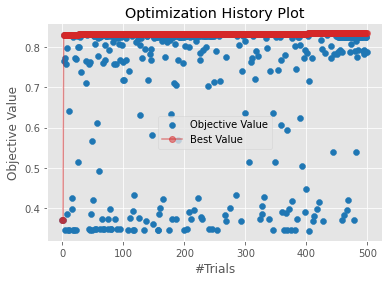

In [157]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [158]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [159]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,205.200000,6.844300
1,TN,172.800000,8.904431
2,FP,40.200000,10.982815
3,FN,31.000000,5.696002
4,Accuracy,0.841491,0.017411
5,Precision,0.837477,0.037982
6,Sensitivity,0.869071,0.021360
7,Specificity,0.812100,0.046704
8,F1 score,0.852175,0.015481
9,F1 score (weighted),0.841171,0.017763


In [160]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,401.000000,402.000000,409.000000,418.000000,409.000000,393.000000,411.000000,406.000000,420.000000,427.000000,409.600000,10.024415
1,TN,357.000000,358.000000,349.000000,347.000000,351.000000,343.000000,334.000000,349.000000,351.000000,330.000000,346.900000,9.036346
2,FP,77.000000,85.000000,75.000000,82.000000,100.000000,90.000000,95.000000,89.000000,63.000000,75.000000,83.100000,10.989389
3,FN,64.000000,54.000000,66.000000,52.000000,39.000000,73.000000,59.000000,55.000000,65.000000,67.000000,59.400000,9.766155
4,Accuracy,0.843159,0.845384,0.843159,0.850945,0.845384,0.818687,0.828699,0.839822,0.857620,0.842047,0.841491,0.010914
5,Precision,0.838912,0.825462,0.845041,0.836000,0.803536,0.813665,0.812253,0.820202,0.869565,0.850598,0.831523,0.020295
6,Sensitivity,0.862366,0.881579,0.861053,0.889362,0.912946,0.843348,0.874468,0.880694,0.865979,0.864372,0.873617,0.019013
7,Specificity,0.822600,0.808100,0.823100,0.808900,0.778300,0.792100,0.778600,0.796800,0.847800,0.814800,0.807110,0.021574
8,F1 score,0.850477,0.852598,0.852972,0.861856,0.854754,0.828240,0.842213,0.849372,0.867769,0.857430,0.851768,0.010817
9,F1 score (weighted),0.843048,0.845122,0.843054,0.850550,0.844704,0.818496,0.828107,0.839436,0.857644,0.841893,0.841205,0.010969


In [161]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_svm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_svm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_svm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_svm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_svm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_svm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_svm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_svm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_svm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_svm))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
svm_5preds = pd.concat([svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4487,4487,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4488,4488,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4489,4489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4490,4490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
mat_met_optimized_svm.to_csv('mat_met_svm_opt.csv')
svm_5preds.to_csv('svm_5test_CV_result.csv')

In [163]:
#cross valide using this optimized SVC 
svm_baseline_CVscore = cross_val_score(svm_clf, X, Y, cv=10, scoring="f1_macro")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="f1_macro")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="f1_macro")
print("SVM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model f1_score 0.8252 with a standard deviation of 0.0208
SVM optimized model f1_score 0.8429 with a standard deviation of 0.0165


In [164]:
joblib.dump(svm_clf, "./svm_clf.joblib")
#joblib.dump(optimized_svm, "./optimized_svm.joblib")
joblib.dump(optimizedCV_svm, "./optimizedCV_svm_clf.joblib")

['./optimizedCV_svm_clf.joblib']